In [1]:
import pandas as pd
import sys
from pathlib import Path
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(str(Path.cwd().parent.parent / "src")) # Necessário contar quantos niveis subir nas pastas, incluir 1 .parent para cada nivel.

# My custom functions and classes
from utils.paths import resolve_env_path, PROJECT_ROOT
from classes.time_series_dataset import TimeSeriesDataset
from classes.plotter import Plotter
from utils.calculations import plot_stl_decomposition
from utils.calculations import process_df

In [51]:
df_rj = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "xgboost_features_ALL_CONTINENTS_CLEAN.csv")

In [33]:
df_rj = df_rj2.drop_duplicates().copy()

In [52]:
df_rj

date continent  arrivals  year     month_sin     month_cos  \
0     2002-01-01    Africa    1598.0  2002  5.000000e-01  8.660254e-01   
1     2002-02-01    Africa    1479.0  2002  8.660254e-01  5.000000e-01   
2     2002-03-01    Africa    1372.0  2002  1.000000e+00  6.123234e-17   
3     2002-04-01    Africa    1046.0  2002  8.660254e-01 -5.000000e-01   
4     2002-05-01    Africa    1101.0  2002  5.000000e-01 -8.660254e-01   
...          ...       ...       ...   ...           ...           ...   
2203  2024-08-01     TOTAL   91504.0  2024 -8.660254e-01 -5.000000e-01   
2204  2024-09-01     TOTAL  116003.0  2024 -1.000000e+00 -1.836970e-16   
2205  2024-10-01     TOTAL  130985.0  2024 -8.660254e-01  5.000000e-01   
2206  2024-11-01     TOTAL  145148.0  2024 -5.000000e-01  8.660254e-01   
2207  2024-12-01     TOTAL  176121.0  2024 -2.449294e-16  1.000000e+00   

       quarter_sin   quarter_cos     lag_1     lag_2  ...  \
0     1.000000e+00  6.123234e-17    1273.0    1179.0  ...   
1     1.000000e+00  6.123234e-17    1598.0    1273.0  ...   
2     1.000000e+00  6.123234e-17    1479.0    1598.0  ...   
3     1.224647e-16 -1.000000e+00    1372.0    1479.0  ...   
4     1.224647e-16 -1.000000e+00    1046.0    1372.0  ...   
...            ...           ...       ...       ...  ...   
2203 -1.000000e+00 -1.836970e-16  108089.0   82402.0  ...   
2204 -1.000000e+00 -1.836970e-16   91504.0  108089.0  ...   
2205 -2.449294e-16  1.000000e+00  116003.0   91504.0  ...   
2206 -2.449294e-16  1.000000e+00  130985.0  116003.0  ...   
2207 -2.449294e-16  1.000000e+00  145148.0  130985.0  ...   

      FC_LocalSimple_mean1_tauresrat  DN_OutlierInclude_p_001_mdrmd  \
0                           0.666667                       0.166667   
1                           0.666667                       0.083333   
2                           0.666667                       0.000000   
3                           0.666667                      -0.083333   
4                           0.666667                      -0.166667   
...                              ...                            ...   
2203                        0.750000                       0.541667   
2204                        1.000000                       0.458333   
2205                        1.000000                       0.375000   
2206                        1.000000                       0.333333   
2207                        1.000000                       0.291667   

      DN_OutlierInclude_n_001_mdrmd  SP_Summaries_welch_rect_area_5_1  \
0                         -0.083333                          0.446326   
1                         -0.166667                          0.419320   
2                         -0.250000                          0.431103   
3                         -0.333333                          0.442858   
4                         -0.125000                          0.375035   
...                             ...                               ...   
2203                      -0.125000                          0.393025   
2204                      -0.208333                          0.396151   
2205                      -0.250000                          0.409596   
2206                      -0.250000                          0.398270   
2207                      -0.291667                          0.377053   

      SB_BinaryStats_diff_longstretch0  SB_MotifThree_quantile_hh  \
0                                  6.0                   2.054356   
1                                  6.0                   2.102866   
2                                  6.0                   2.102866   
3                                  6.0                   2.077106   
4                                  6.0                   2.077106   
...                                ...                        ...   
2203                               5.0                   1.885300   
2204                               5.0                   1.994083   
2205                               5.0 

In [53]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from itertools import product
warnings.filterwarnings('ignore')

print("="*80)
print("XGBOOST GRIDSEARCH - MODELO INDIVIDUAL POR CONTINENTE")
print("="*80 + "\n")

# ========================================
# GRID DE HIPERPARÂMETROS
# ========================================
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
}

print("Grid de hiperparâmetros:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal de combinações: {total_combinations}")
print(f"Critério de seleção: MENOR RMSE DE TESTE\n")

# ========================================
# TRAINING PIPELINE
# ========================================
train_end = pd.Timestamp('2023-12-31')
test_start = pd.Timestamp('2024-01-01')

print(f"Training period: até {train_end.strftime('%Y-%m-%d')}")
print(f"Test period: de {test_start.strftime('%Y-%m-%d')} em diante")
print("\n" + "="*80 + "\n")

# ✅ CONVERSÃO DE DATA
df_rj['date'] = pd.to_datetime(df_rj['date'])

# Get unique continents from df_rj
continents = sorted(df_rj['continent'].unique())
print(f"Continentes encontrados no df_rj: {len(continents)}")
for i, cont in enumerate(continents, 1):
    print(f"  {i}. {cont}")

print("\n" + "="*80 + "\n")

# Storage for models and results
xgb_models = {}
xgb_results = []
all_gridsearch_results = []

# ========================================
# GRIDSEARCH POR CONTINENTE
# ========================================
for continent in continents:
    print(f"\n{'='*80}")
    print(f"GRIDSEARCH: {continent.upper()}")
    print(f"{'='*80}\n")
    
    # ✅ FILTRAR DADOS DO CONTINENTE
    continent_data = df_rj[df_rj['continent'] == continent].copy()
    
    print(f"Observações totais: {len(continent_data)}")
    print(f"Período: {continent_data['date'].min().strftime('%Y-%m')} a {continent_data['date'].max().strftime('%Y-%m')}")
    
    if len(continent_data) == 0:
        print(f"\n⚠️ AVISO: Sem dados para {continent} - pulando")
        continue
    
    # ✅ SPLIT TRAIN/TEST
    train_data = continent_data[continent_data['date'] <= train_end].copy()
    test_data = continent_data[continent_data['date'] >= test_start].copy()
    
    print(f"\nTrain: {len(train_data)} obs | Test: {len(test_data)} obs")
    
    if len(test_data) == 0:
        print("\n⚠️ AVISO: Sem dados de teste - pulando continente")
        continue
    
    # ✅ DEFINIR FEATURES E TARGET
    feature_cols = [col for col in continent_data.columns 
                    if col not in ['date', 'continent', 'arrivals']]
    
    X_train = train_data[feature_cols]
    y_train = train_data['arrivals']
    X_test = test_data[feature_cols]
    y_test = test_data['arrivals']
    
    print(f"Features: {len(feature_cols)} | Shape: {X_train.shape}")
    
    # ✅ VERIFICAR NaNs
    if X_train.isna().any().any() or X_test.isna().any().any():
        print(f"\n⚠️ ATENÇÃO: Features contêm NaNs - pulando")
        continue
    
    # ========================================
    # GRID SEARCH
    # ========================================
    print(f"\nIniciando GridSearch ({total_combinations} combinações)...\n")
    start_time = time.time()
    
    best_rmse_test = float('inf')
    best_params = None
    best_model = None
    best_rmse_train = None
    best_gap = None
    
    all_results = []
    
    # Gerar todas as combinações
    param_combinations = list(product(
        param_grid['n_estimators'],
        param_grid['learning_rate'],
        param_grid['max_depth'],
        param_grid['min_child_weight'],
        param_grid['subsample'],
        param_grid['colsample_bytree']
    ))

    # Loop por todas as combinações
    for i, (n_est, lr, md, mcw, ss, csb) in enumerate(param_combinations, 1):
        # Criar modelo
        model = xgb.XGBRegressor(
            n_estimators=n_est,
            learning_rate=lr,
            max_depth=md,
            min_child_weight=mcw,
            subsample=ss,
            colsample_bytree=csb,
            random_state=42,
            verbosity=0
        )
        
        # Treinar
        model.fit(X_train, y_train)
        
        # Predizer
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Métricas
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        
        # MAPE
        mask_train = y_train > 0
        mask_test = y_test > 0
        
        mape_train = np.mean(np.abs((y_train[mask_train] - y_pred_train[mask_train]) / y_train[mask_train])) * 100 if mask_train.sum() > 0 else np.nan
        mape_test = np.mean(np.abs((y_test[mask_test] - y_pred_test[mask_test]) / y_test[mask_test])) * 100 if mask_test.sum() > 0 else np.nan
        
        # GAP
        gap = abs(rmse_train - rmse_test)

        # Ljung-Box Test
        residuals_train = y_train.values - y_pred_train

        try:
            from statsmodels.stats.diagnostic import acorr_ljungbox
            lb_test = acorr_ljungbox(residuals_train, lags=24, return_df=True)
            lb_pvalue = lb_test['lb_pvalue'].iloc[-1]
            lb_statistic = lb_test['lb_stat'].iloc[-1]
            lb_result = "Pass" if lb_pvalue > 0.05 else "Fail"
        except Exception as e:
            lb_pvalue = np.nan
            lb_statistic = np.nan
            lb_result = "Error"
        
        # Armazenar
        params = {
            'n_estimators': n_est,
            'learning_rate': lr,
            'max_depth': md,
            'min_child_weight': mcw,
            'subsample': ss,
            'colsample_bytree': csb
        }
        
        all_results.append({
            'continent': continent,
            'iteration': i,
            'params': params,
            'n_estimators': n_est,
            'learning_rate': lr,
            'max_depth': md,
            'min_child_weight': mcw,
            'subsample': ss,
            'colsample_bytree': csb,
            'rmse_train': rmse_train,
            'rmse_test': rmse_test,
            'mae_train': mae_train,
            'mae_test': mae_test,
            'mape_train': mape_train,
            'mape_test': mape_test,
            'gap': gap,
            'ratio': rmse_test / rmse_train if rmse_train > 0 else float('inf'),
            'lb_pvalue': lb_pvalue,
            'lb_statistic': lb_statistic,
            'lb_result': lb_result
        })
        
        # Atualizar melhor modelo
        if rmse_test < best_rmse_test:
            best_rmse_test = rmse_test
            best_rmse_train = rmse_train
            best_gap = gap
            best_params = params.copy()
            best_model = model
        
        # Progress
        if i % 30 == 0 or i == len(param_combinations):
            print(f"  {i}/{len(param_combinations)} ({i/len(param_combinations)*100:.1f}%) | Melhor RMSE Test: {best_rmse_test:.2f}")
    
    elapsed_time = time.time() - start_time
    
    # ========================================
    # RESULTADOS
    # ========================================
    print(f"\n{'='*60}")
    print(f"RESULTADOS - {continent.upper()}")
    print(f"{'='*60}")
    print(f"Tempo: {elapsed_time:.2f}s ({elapsed_time/60:.2f} min)")
    print(f"\nMelhor modelo:")
    print(f"  RMSE Train: {best_rmse_train:.2f}")
    print(f"  RMSE Test:  {best_rmse_test:.2f}")
    print(f"  GAP:        {best_gap:.2f}")
    print(f"  Ratio:      {best_rmse_test / best_rmse_train:.2f}")
    
    print(f"\nMelhores parâmetros:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    # Métricas finais
    y_pred_train_final = best_model.predict(X_train)
    y_pred_test_final = best_model.predict(X_test)
    
    mae_train_final = mean_absolute_error(y_train, y_pred_train_final)
    mae_test_final = mean_absolute_error(y_test, y_pred_test_final)
    
    mask_train = y_train > 0
    mask_test = y_test > 0
    
    mape_train_final = np.mean(np.abs((y_train[mask_train] - y_pred_train_final[mask_train]) / y_train[mask_train])) * 100 if mask_train.sum() > 0 else np.nan
    mape_test_final = np.mean(np.abs((y_test[mask_test] - y_pred_test_final[mask_test]) / y_test[mask_test])) * 100 if mask_test.sum() > 0 else np.nan
    
    print(f"\nTRAIN: RMSE={best_rmse_train:.2f} | MAE={mae_train_final:.2f} | MAPE={mape_train_final:.2f}%")
    print(f"TEST:  RMSE={best_rmse_test:.2f} | MAE={mae_test_final:.2f} | MAPE={mape_test_final:.2f}%")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Top 5 modelos
    all_results_df = pd.DataFrame(all_results)
    all_results_df = all_results_df.sort_values('rmse_test')
    
    print(f"\nTop 5 Modelos (Menor RMSE Test):")
    for idx, (_, row) in enumerate(all_results_df.head(5).iterrows(), 1):
        print(f"{idx}. RMSE Test={row['rmse_test']:.2f} | Train={row['rmse_train']:.2f} | GAP={row['gap']:.2f}")
    
    all_gridsearch_results.append(all_results_df)
    
    # Armazenar
    xgb_models[continent] = {
        'model': best_model,
        'feature_cols': feature_cols,
        'train_data': train_data,
        'test_data': test_data,
        'y_pred_train': y_pred_train_final,
        'y_pred_test': y_pred_test_final,
        'feature_importance': feature_importance,
        'all_results': all_results_df
    }
    
    xgb_results.append({
        'Continent': continent,
        'Train_RMSE': best_rmse_train,
        'Test_RMSE': best_rmse_test,
        'GAP': best_gap,
        'Ratio': best_rmse_test / best_rmse_train,
        'Train_MAE': mae_train_final,
        'Test_MAE': mae_test_final,
        'Train_MAPE': mape_train_final,
        'Test_MAPE': mape_test_final,
        'n_estimators': best_params['n_estimators'],
        'learning_rate': best_params['learning_rate'],
        'max_depth': best_params['max_depth'],
        'min_child_weight': best_params['min_child_weight'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'Time_min': elapsed_time / 60
    })
    
    print(f"\n✓ GridSearch para {continent} concluído!")


# ========================================
# RESUMO GERAL
# ========================================
print("\n" + "="*80)
print("RESUMO GRIDSEARCH - TODOS OS CONTINENTES")
print("="*80 + "\n")

results_df = pd.DataFrame(xgb_results)
print(results_df[['Continent', 'Train_RMSE', 'Test_RMSE', 'GAP', 'Ratio', 'Test_MAE', 'Test_MAPE']].to_string(index=False))

print("\n" + "="*80)
print("RANKING POR TEST RMSE")
print("="*80 + "\n")

ranking_test = results_df.sort_values('Test_RMSE')[['Continent', 'Test_RMSE', 'Test_MAE', 'Test_MAPE', 'GAP', 'Ratio']]
print(ranking_test.to_string(index=False))

print("\n" + "="*80)
print("RANKING POR MENOR GAP")
print("="*80 + "\n")

ranking_gap = results_df.sort_values('GAP')[['Continent', 'Train_RMSE', 'Test_RMSE', 'GAP', 'Ratio']]
print(ranking_gap.to_string(index=False))

print("\n" + "="*80)
print("ESTATÍSTICAS DOS HIPERPARÂMETROS")
print("="*80 + "\n")

print(f"n_estimators - Média: {results_df['n_estimators'].mean():.0f} | Moda: {results_df['n_estimators'].mode()[0]}")
print(f"learning_rate - Média: {results_df['learning_rate'].mean():.3f} | Moda: {results_df['learning_rate'].mode()[0]}")
print(f"max_depth - Média: {results_df['max_depth'].mean():.1f} | Moda: {results_df['max_depth'].mode()[0]}")
print(f"min_child_weight - Média: {results_df['min_child_weight'].mean():.1f} | Moda: {results_df['min_child_weight'].mode()[0]}")
print(f"subsample - Média: {results_df['subsample'].mean():.2f} | Moda: {results_df['subsample'].mode()[0]}")
print(f"colsample_bytree - Média: {results_df['colsample_bytree'].mean():.2f} | Moda: {results_df['colsample_bytree'].mode()[0]}")

print("\n" + "="*80)
print("✓ GRIDSEARCH CONCLUÍDO")
print("="*80)

# ✅ SALVAR RESULTADOS
if len(all_gridsearch_results) > 0:
    all_gridsearch_df = pd.concat(all_gridsearch_results, ignore_index=True)
    
    output_path_gridsearch = PROJECT_ROOT / "notebooks" / "modeling" / "xgboost_gridsearch_full_catch.csv"
    all_gridsearch_df.to_csv(output_path_gridsearch, index=False)
    
    print(f"\n✓ Resultados salvos em: {output_path_gridsearch}")
    display(all_gridsearch_df.head(10))

XGBOOST GRIDSEARCH - MODELO INDIVIDUAL POR CONTINENTE

Grid de hiperparâmetros:
  n_estimators: [100, 150, 200]
  learning_rate: [0.01, 0.03, 0.05]
  max_depth: [3, 4, 5]
  min_child_weight: [1, 3, 5]
  subsample: [0.6, 0.7, 0.8]
  colsample_bytree: [0.6, 0.7, 0.8]

Total de combinações: 729
Critério de seleção: MENOR RMSE DE TESTE

Training period: até 2023-12-31
Test period: de 2024-01-01 em diante


Continentes encontrados no df_rj: 8
  1. Africa
  2. America_Central_E_Caribe
  3. America_Do_Norte
  4. America_Do_Sul
  5. Asia
  6. Europa
  7. Oceania
  8. TOTAL



GRIDSEARCH: AFRICA

Observações totais: 276
Período: 2002-01 a 2024-12

Train: 264 obs | Test: 12 obs
Features: 41 | Shape: (264, 41)

Iniciando GridSearch (729 combinações)...

  30/729 (4.1%) | Melhor RMSE Test: 569.55
  60/729 (8.2%) | Melhor RMSE Test: 540.34
  90/729 (12.3%) | Melhor RMSE Test: 319.75
  120/729 (16.5%) | Melhor RMSE Test: 265.96
  150/729 (20.6%) | Melhor RMSE Test: 203.20
  180/729 (24.7%) | Melhor 

continent  iteration                                             params  \
0    Africa        647  {'n_estimators': 200, 'learning_rate': 0.03, '...   
1    Africa        648  {'n_estimators': 200, 'learning_rate': 0.03, '...   
2    Africa        723  {'n_estimators': 200, 'learning_rate': 0.05, '...   
3    Africa        405  {'n_estimators': 150, 'learning_rate': 0.03, '...   
4    Africa        621  {'n_estimators': 200, 'learning_rate': 0.03, '...   
5    Africa        396  {'n_estimators': 150, 'learning_rate': 0.03, '...   
6    Africa        639  {'n_estimators': 200, 'learning_rate': 0.03, '...   
7    Africa        404  {'n_estimators': 150, 'learning_rate': 0.03, '...   
8    Africa        378  {'n_estimators': 150, 'learning_rate': 0.03, '...   
9    Africa        726  {'n_estimators': 200, 'learning_rate': 0.05, '...   

   n_estimators  learning_rate  max_depth  min_child_weight  subsample  \
0           200           0.03          5                 5        0.8   
1           200           0.03          5                 5        0.8   
2           200           0.05          5                 5        0.6   
3           150           0.03          5                 5        0.8   
4           200           0.03          4                 5        0.8   
5           150           0.03          5                 3        0.8   
6           200           0.03          5                 3        0.8   
7           150           0.03          5                 5        0.8   
8           150           0.03          4                 5        0.8   
9           200           0.05          5                 5        0.7   

   colsample_bytree  rmse_train   rmse_test   mae_train    mae_test  \
0               0.7  117.497089  162.924296   75.864790  132.751071   
1               0.8  114.869158  166.852791   74.178313  126.025490   
2               0.8   98.588612  171.230634   59.944611  128.349312   
3               0.8  152.817480  172.361966   98.321501  132.810260   
4               0.8  155.747149  173.992529  106.912836  132.517802   
5               0.8  116.300541  174.901822   80.593957  140.765411   
6               0.8   79.536497  176.785637   55.938541  140.106160   
7               0.7  157.023260  177.402782  100.472524  146.765958   
8               0.8  195.022282  184.292923  132.475895  143.942637   
9               0.8   74.591703  188.623612   46.039979  144.875053   

   mape_train  mape_test         gap     ratio  lb_pvalue  lb_statistic  \
0    6.486383  41.916580   45.427207  1.386624   0.013384     41.858380   
1    6.412185  39.955890   51.983633  1.452546   0.015090     41.389483   
2    5.316671  39.820554   72.642022  1.736820   0.079738     34.284494   
3    8.286396  42.173831   19.544486  1.127894   0.007847     43.895295   
4    9.045886  42.977001   18.245379  1.117147   0.014090     41.658128   
5    7.087137  44.239554   58.601281  1.503878   0.033947     38.089596   
6    5.097644  43.789142   97.249140  2.222698   0.036432     37.789466   
7    8.463968  46.690317   20.379522  1.129787   0.012134     42.238351   
8   11.153836  46.841231   10.729359  0.944984   0.007340     44.144798   
9    4.226217  46.759013  114.031909  2.528748   0.012294     42.187775   

  lb_result  
0      Fail  
1      Fail  
2      Pass  
3      Fail  
4      Fail  
5      Fail  
6      Fail  
7      Fail  
8      Fail  
9      Fail

In [55]:
results_df

Continent   Train_RMSE     Test_RMSE           GAP  \
0                    Africa   117.497089    162.924296     45.427207   
1  America_Central_E_Caribe   203.507230    298.916792     95.409562   
2          America_Do_Norte  1143.216506   4153.715181   3010.498675   
3            America_Do_Sul   904.491576  17174.121668  16269.630092   
4                      Asia   358.136803    889.245118    531.108314   
5                    Europa   815.940441   3980.165968   3164.225526   
6                   Oceania   290.237162    221.658051     68.579111   
7                     TOTAL  8108.779062  27706.261684  19597.482622   

       Ratio    Train_MAE      Test_MAE  Train_MAPE  Test_MAPE  n_estimators  \
0   1.386624    75.864790    132.751071    6.486383  41.916580           200   
1   1.468826   101.224805    241.270208   12.699291  17.751098           200   
2   3.633358   862.647011   3565.670329    5.846470  18.126543           200   
3  18.987597   652.079006  13895.356445    2.752558  17.677593           200   
4   2.482976   196.387260    572.300252    6.470424  18.380688           200   
5   4.878010   577.145326   3422.459961    1.863218  11.561583           200   
6   0.763714   136.321743    191.775004   11.587935  20.462988           150   
7   3.416823  4963.542267  24120.341797    5.647549  17.945289           150   

   learning_rate  max_depth  min_child_weight  subsample  colsample_bytree  \
0           0.03          5                 5        0.8               0.7   
1           0.03          4                 5        0.6               0.8   
2           0.05          3                 1        0.8               0.8   
3           0.05          4                 1        0.8               0.8   
4           0.05          5                 5        0.8               0.7   
5           0.05          5                 1        0.6               0.6   
6           0.03          5                 3        0.7               0.7   
7           0.05          3                 5        0.6               0.8   

   Time_min  
0  1.547905  
1  1.355907  
2  1.403164  
3  1.479341  
4  1.424533  
5  1.501590  
6  1.414708  
7  1.920713

In [ ]:
output_path_results_df = PROJECT_ROOT / "notebooks" / "modeling" / "xgboost_results_df_full.csv"
results_df.to_csv(output_path_results_df, index=False)

ANÁLISE SHAP E SELEÇÃO DE FEATURES - TOP 95%


SHAP ANALYSIS: AFRICA

Features originais: 41

Calculando SHAP values...
⚠️ ERRO ao calcular SHAP: could not convert string to float: '[1.4670454E3]'
Tentando método alternativo...

--- Feature Selection (95% Importance) ---
Features selecionadas: 33 (80.5%)
Features removidas: 8 (19.5%)

Features REMOVIDAS (8):
  1. trend_strength (Imp: 0.011298, Acum: 96.86%)
  2. seasonal_peak_year (Imp: 0.009819, Acum: 98.93%)
  3. linearity (Imp: 0.002255, Acum: 100.00%)
  4. curvature (Imp: 0.012967, Acum: 95.73%)
  5. DN_HistogramMode_5 (Imp: 0.010848, Acum: 97.95%)
  6. MD_hrv_classic_pnn40 (Imp: 0.008450, Acum: 99.77%)
  7. SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  8. SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)

Top 10 Features MANTIDAS:
  1. lag_1 (Imp: 0.135581, Acum: 13.56%)
  2. lag_3 (Imp: 0.069822, Acum: 20.54%)
  3. SB_BinaryStats_mean_longstretch1 (Imp: 0.049898, Acum: 25.53%)
  

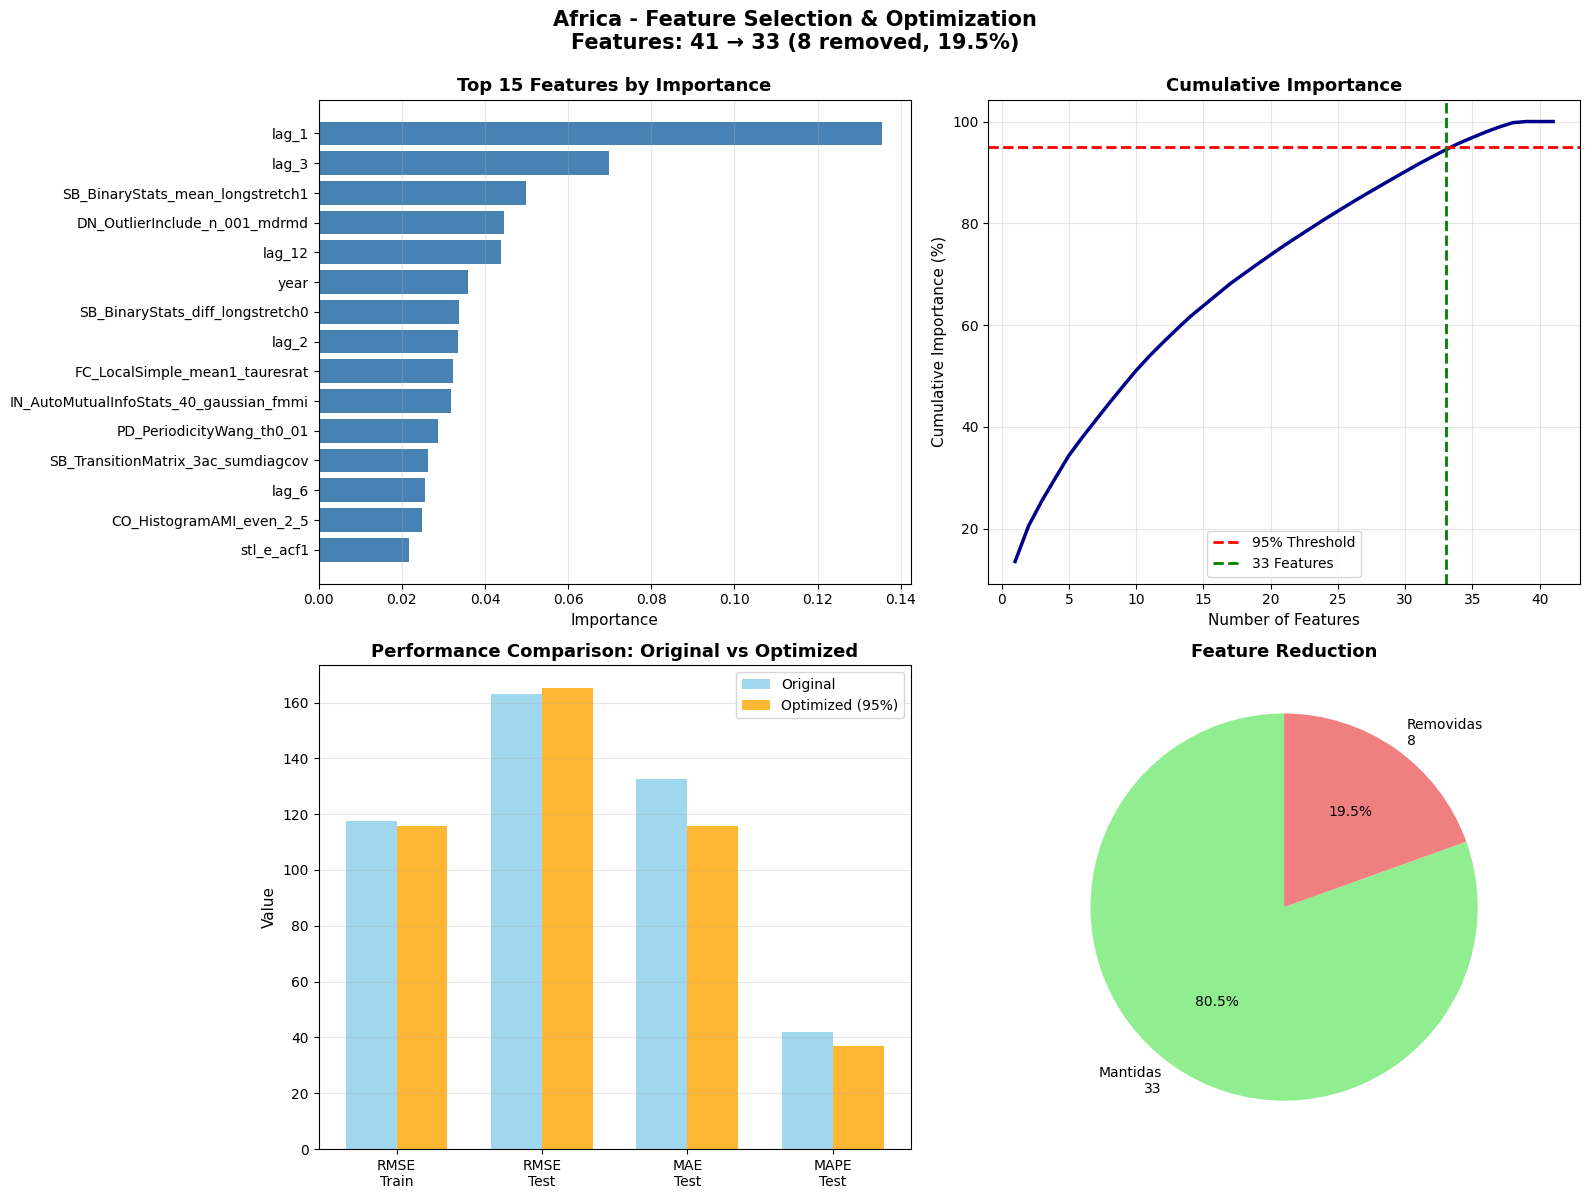


✓ Análise para Africa concluída!

SHAP ANALYSIS: AMERICA_CENTRAL_E_CARIBE

Features originais: 41

Calculando SHAP values...
⚠️ ERRO ao calcular SHAP: could not convert string to float: '[8.3216766E2]'
Tentando método alternativo...

--- Feature Selection (95% Importance) ---
Features selecionadas: 30 (73.2%)
Features removidas: 11 (26.8%)

Features REMOVIDAS (11):
  1. lag_6 (Imp: 0.013331, Acum: 95.20%)
  2. linearity (Imp: 0.000000, Acum: 100.00%)
  3. stl_e_acf1 (Imp: 0.008453, Acum: 98.02%)
  4. SB_BinaryStats_mean_longstretch1 (Imp: 0.005537, Acum: 100.00%)
  5. IN_AutoMutualInfoStats_40_gaussian_fmmi (Imp: 0.007903, Acum: 98.81%)
  6. FC_LocalSimple_mean1_tauresrat (Imp: 0.000000, Acum: 100.00%)
  7. DN_OutlierInclude_n_001_mdrmd (Imp: 0.010465, Acum: 96.25%)
  8. SB_BinaryStats_diff_longstretch0 (Imp: 0.006361, Acum: 99.45%)
  9. SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  10. SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%

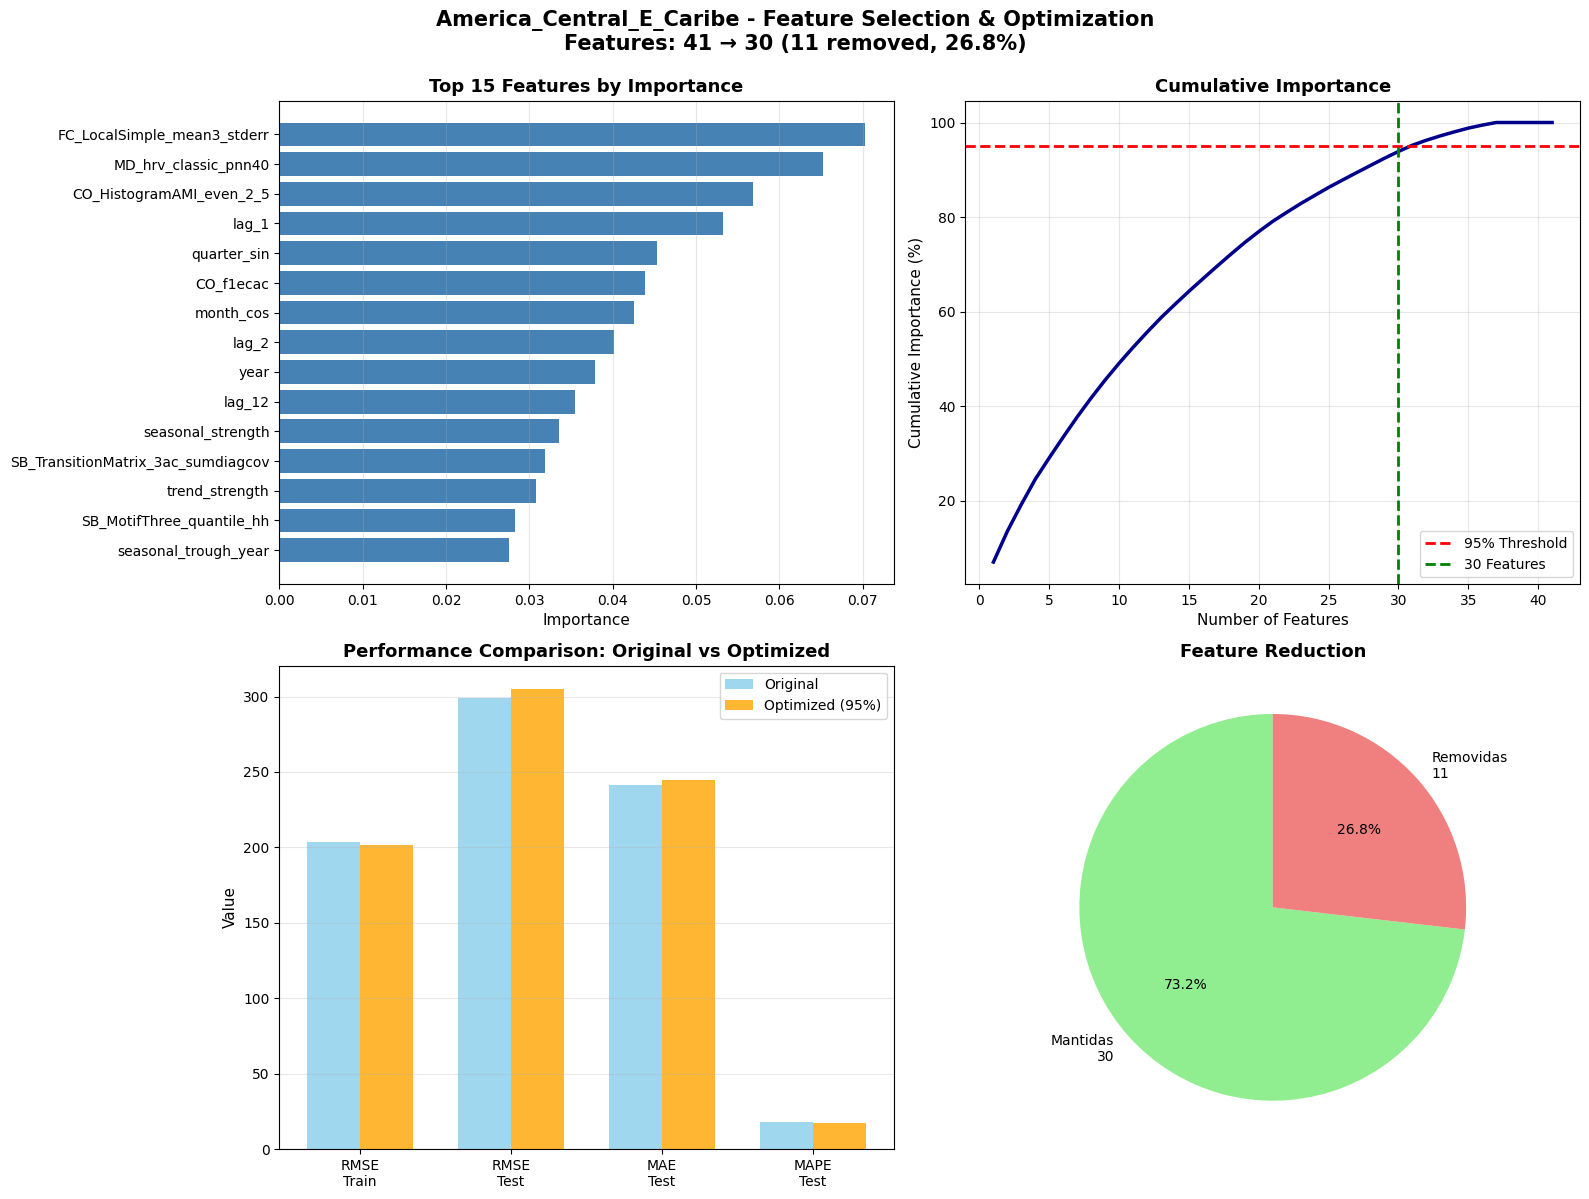


✓ Análise para America_Central_E_Caribe concluída!

SHAP ANALYSIS: AMERICA_DO_NORTE

Features originais: 41

Calculando SHAP values...
⚠️ ERRO ao calcular SHAP: could not convert string to float: '[1.5736821E4]'
Tentando método alternativo...

--- Feature Selection (95% Importance) ---
Features selecionadas: 31 (75.6%)
Features removidas: 10 (24.4%)

Features REMOVIDAS (10):
  1. trend_strength (Imp: 0.005596, Acum: 99.58%)
  2. spikiness (Imp: 0.008218, Acum: 97.58%)
  3. linearity (Imp: 0.000098, Acum: 100.00%)
  4. stl_e_acf1 (Imp: 0.007670, Acum: 98.35%)
  5. CO_FirstMin_ac (Imp: 0.004069, Acum: 99.99%)
  6. MD_hrv_classic_pnn40 (Imp: 0.009163, Acum: 95.92%)
  7. FC_LocalSimple_mean1_tauresrat (Imp: 0.006752, Acum: 99.02%)
  8. SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  9. SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  10. SP_Summaries_welch_rect_centroid (Imp: 0.008438, Acum: 96.76%)

Top 10 Features MANTIDAS:
  1. PD_Per

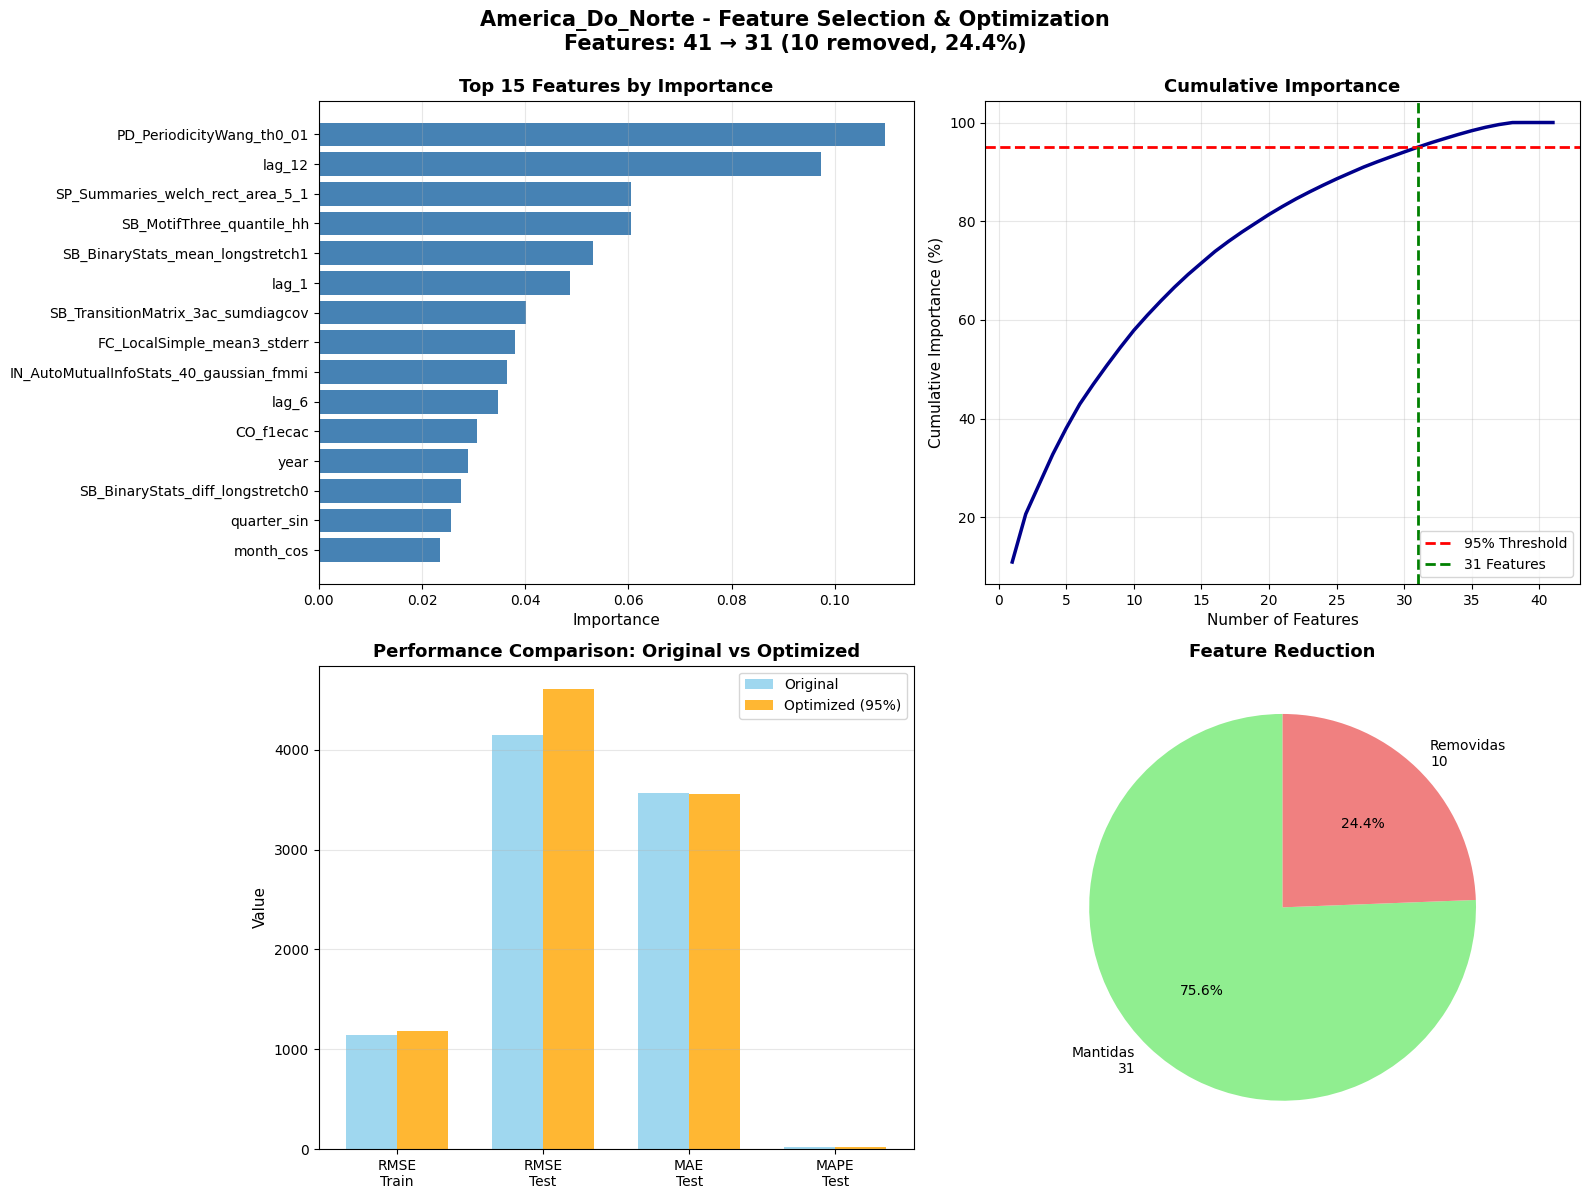


✓ Análise para America_Do_Norte concluída!

SHAP ANALYSIS: AMERICA_DO_SUL

Features originais: 41

Calculando SHAP values...
⚠️ ERRO ao calcular SHAP: could not convert string to float: '[3.515609E4]'
Tentando método alternativo...

--- Feature Selection (95% Importance) ---
Features selecionadas: 24 (58.5%)
Features removidas: 17 (41.5%)

Features REMOVIDAS (17):
  1. month_sin (Imp: 0.003098, Acum: 98.49%)
  2. lag_3 (Imp: 0.003352, Acum: 97.87%)
  3. seasonal_strength (Imp: 0.004296, Acum: 96.81%)
  4. trend_strength (Imp: 0.003011, Acum: 98.79%)
  5. spikiness (Imp: 0.004884, Acum: 96.38%)
  6. linearity (Imp: 0.003143, Acum: 98.18%)
  7. curvature (Imp: 0.002901, Acum: 99.38%)
  8. DN_HistogramMode_10 (Imp: 0.003718, Acum: 97.18%)
  9. CO_FirstMin_ac (Imp: 0.001237, Acum: 100.00%)
  10. CO_Embed2_Dist_tau_d_expfit_meandiff (Imp: 0.002923, Acum: 99.09%)
  ... e mais 7 features

Top 10 Features MANTIDAS:
  1. lag_12 (Imp: 0.537649, Acum: 53.76%)
  2. lag_1 (Imp: 0.129469, Acum: 66.

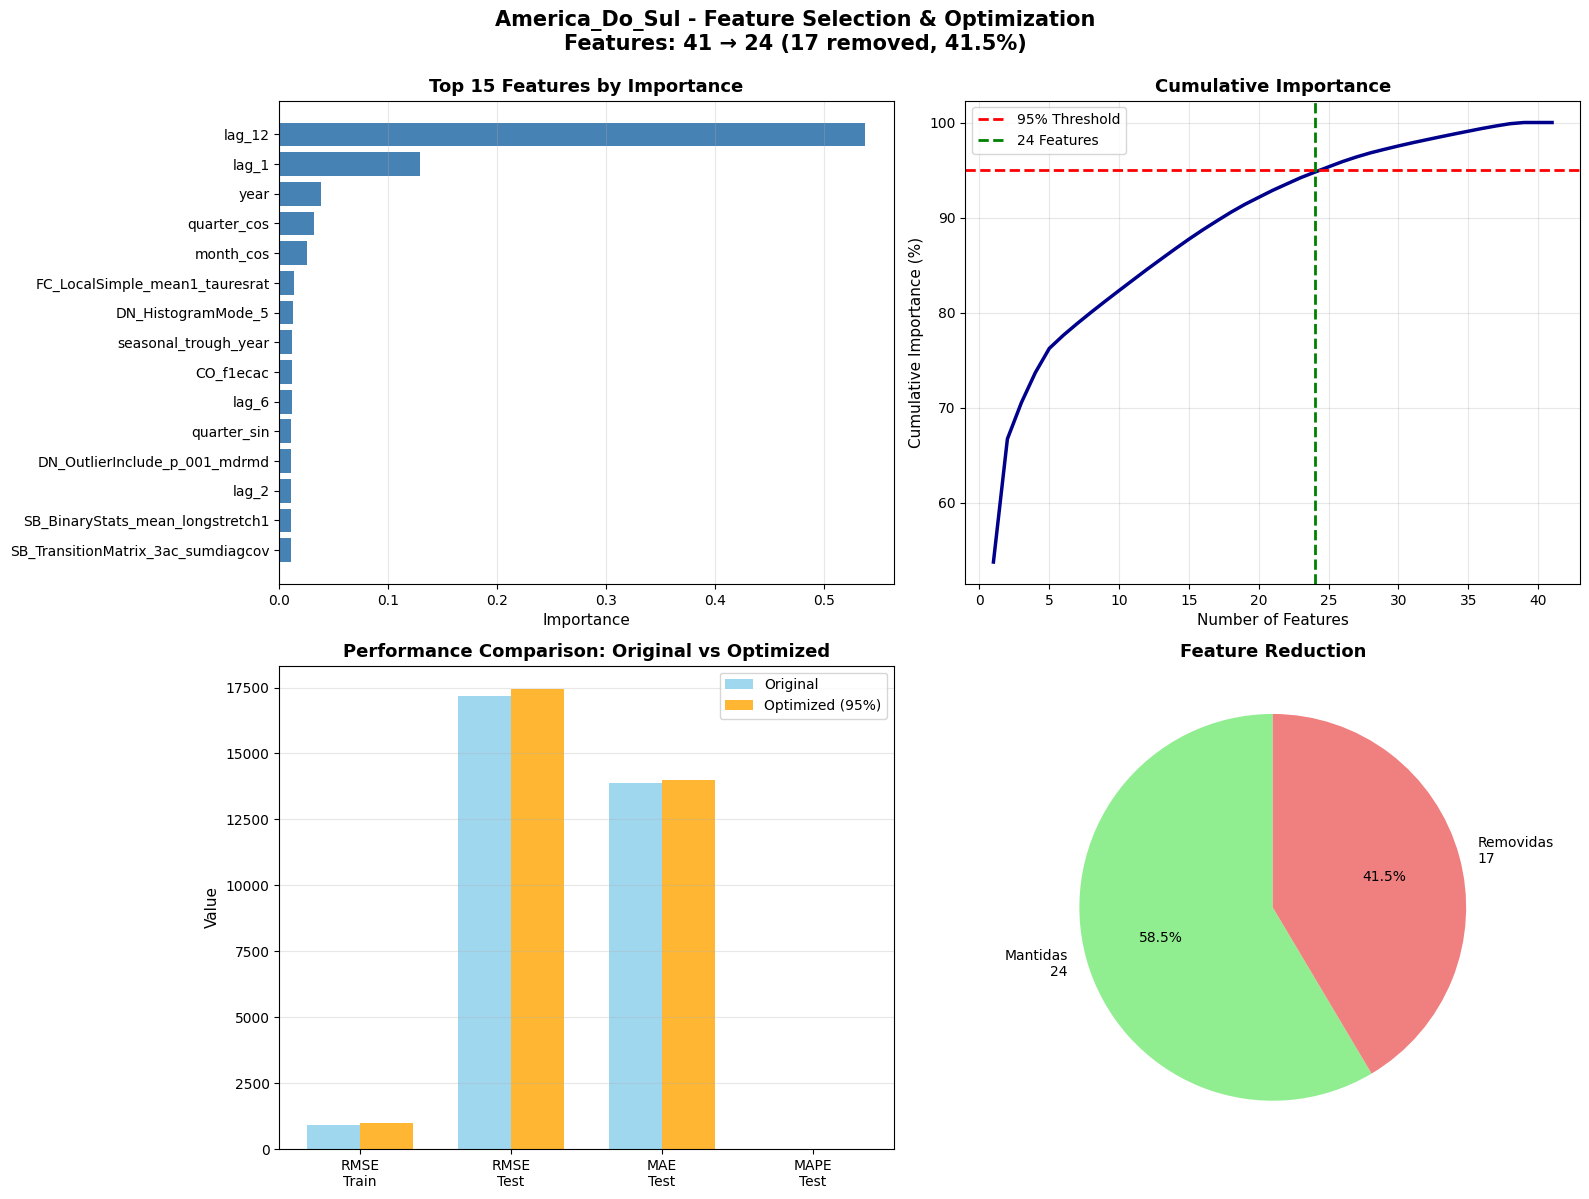


✓ Análise para America_Do_Sul concluída!

SHAP ANALYSIS: ASIA

Features originais: 41

Calculando SHAP values...
⚠️ ERRO ao calcular SHAP: could not convert string to float: '[3.2568955E3]'
Tentando método alternativo...

--- Feature Selection (95% Importance) ---
Features selecionadas: 31 (75.6%)
Features removidas: 10 (24.4%)

Features REMOVIDAS (10):
  1. month_sin (Imp: 0.008603, Acum: 97.94%)
  2. seasonal_peak_year (Imp: 0.010513, Acum: 95.19%)
  3. linearity (Imp: 0.002245, Acum: 100.00%)
  4. stl_e_acf1 (Imp: 0.006310, Acum: 99.35%)
  5. DN_HistogramMode_10 (Imp: 0.007782, Acum: 98.72%)
  6. SB_BinaryStats_mean_longstretch1 (Imp: 0.010064, Acum: 96.19%)
  7. CO_Embed2_Dist_tau_d_expfit_meandiff (Imp: 0.008896, Acum: 97.08%)
  8. FC_LocalSimple_mean1_tauresrat (Imp: 0.004249, Acum: 99.78%)
  9. SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  10. SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)

Top 10 Features MANTIDAS:
  1. SP_

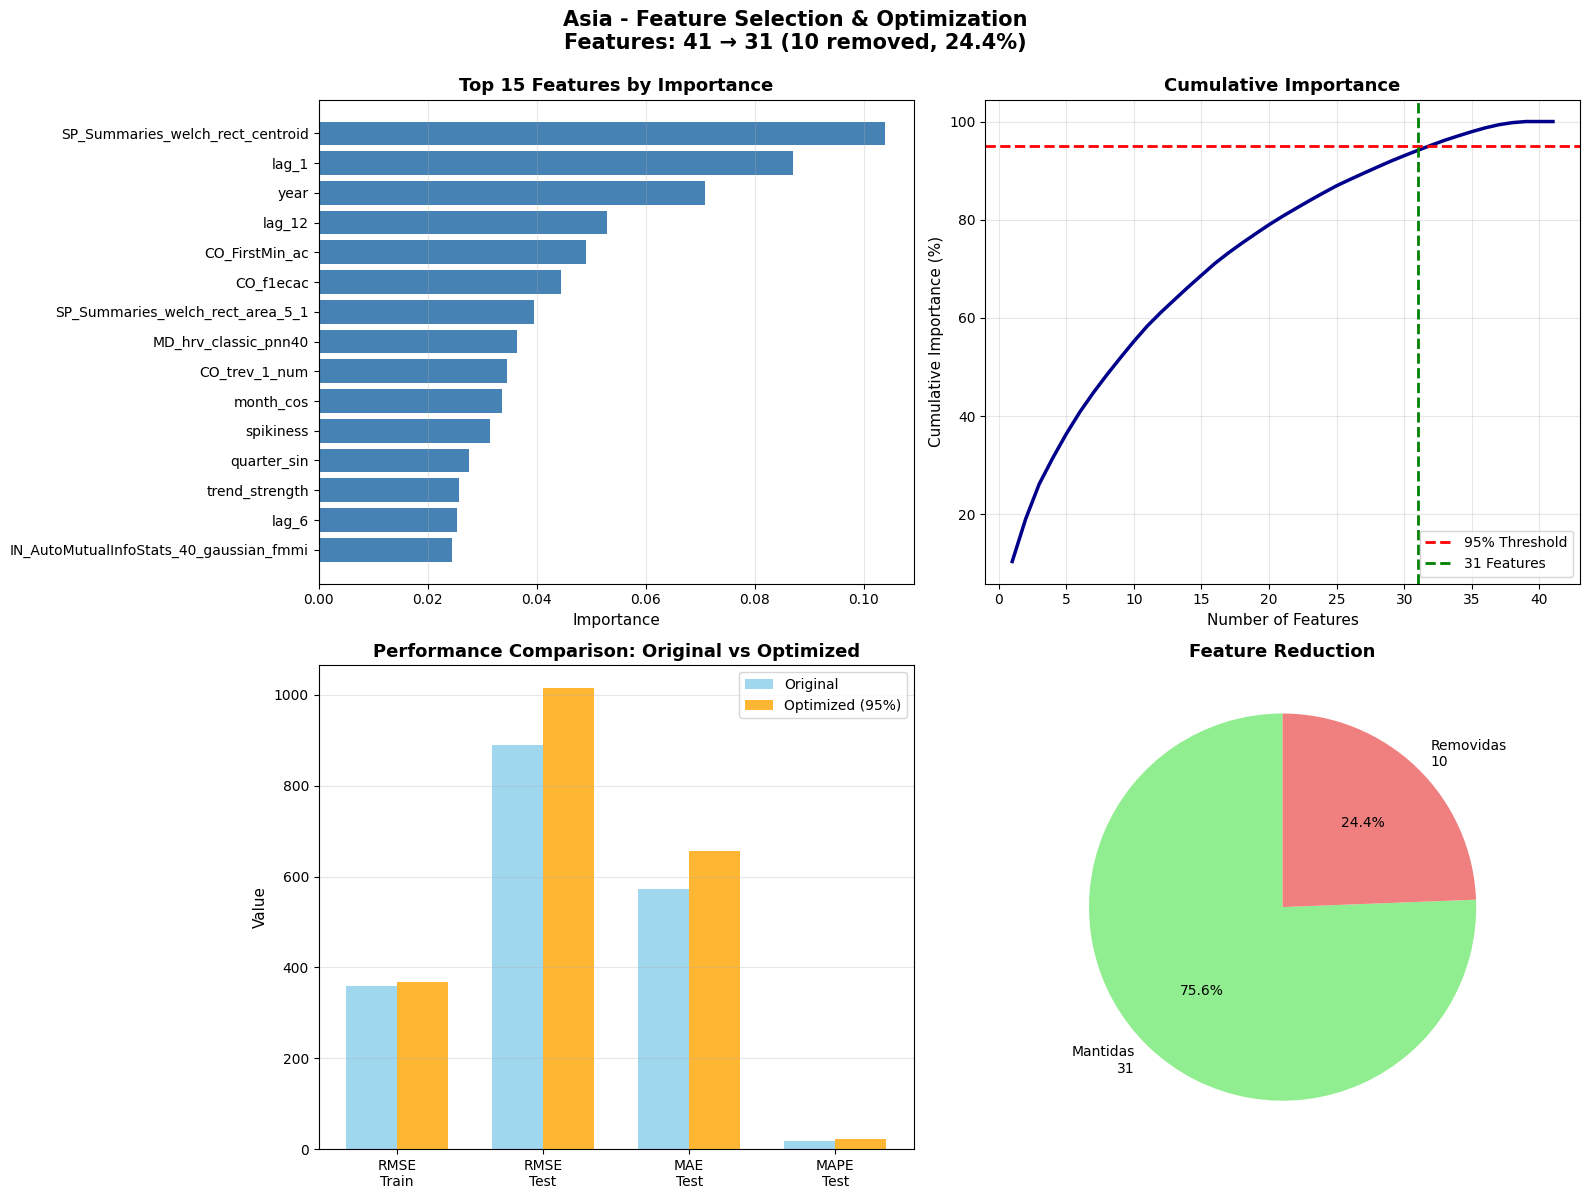


✓ Análise para Asia concluída!

SHAP ANALYSIS: EUROPA

Features originais: 41

Calculando SHAP values...
⚠️ ERRO ao calcular SHAP: could not convert string to float: '[3.3393438E4]'
Tentando método alternativo...

--- Feature Selection (95% Importance) ---
Features selecionadas: 31 (75.6%)
Features removidas: 10 (24.4%)

Features REMOVIDAS (10):
  1. year (Imp: 0.008368, Acum: 96.46%)
  2. seasonal_trough_year (Imp: 0.007239, Acum: 98.81%)
  3. linearity (Imp: 0.002894, Acum: 100.00%)
  4. stl_e_acf10 (Imp: 0.008116, Acum: 98.09%)
  5. CO_FirstMin_ac (Imp: 0.003539, Acum: 99.71%)
  6. CO_HistogramAMI_even_2_5 (Imp: 0.008152, Acum: 97.28%)
  7. MD_hrv_classic_pnn40 (Imp: 0.009106, Acum: 95.62%)
  8. SB_BinaryStats_diff_longstretch0 (Imp: 0.005452, Acum: 99.36%)
  9. SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  10. SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)

Top 10 Features MANTIDAS:
  1. SP_Summaries_welch_rect_centroid (Imp: 0

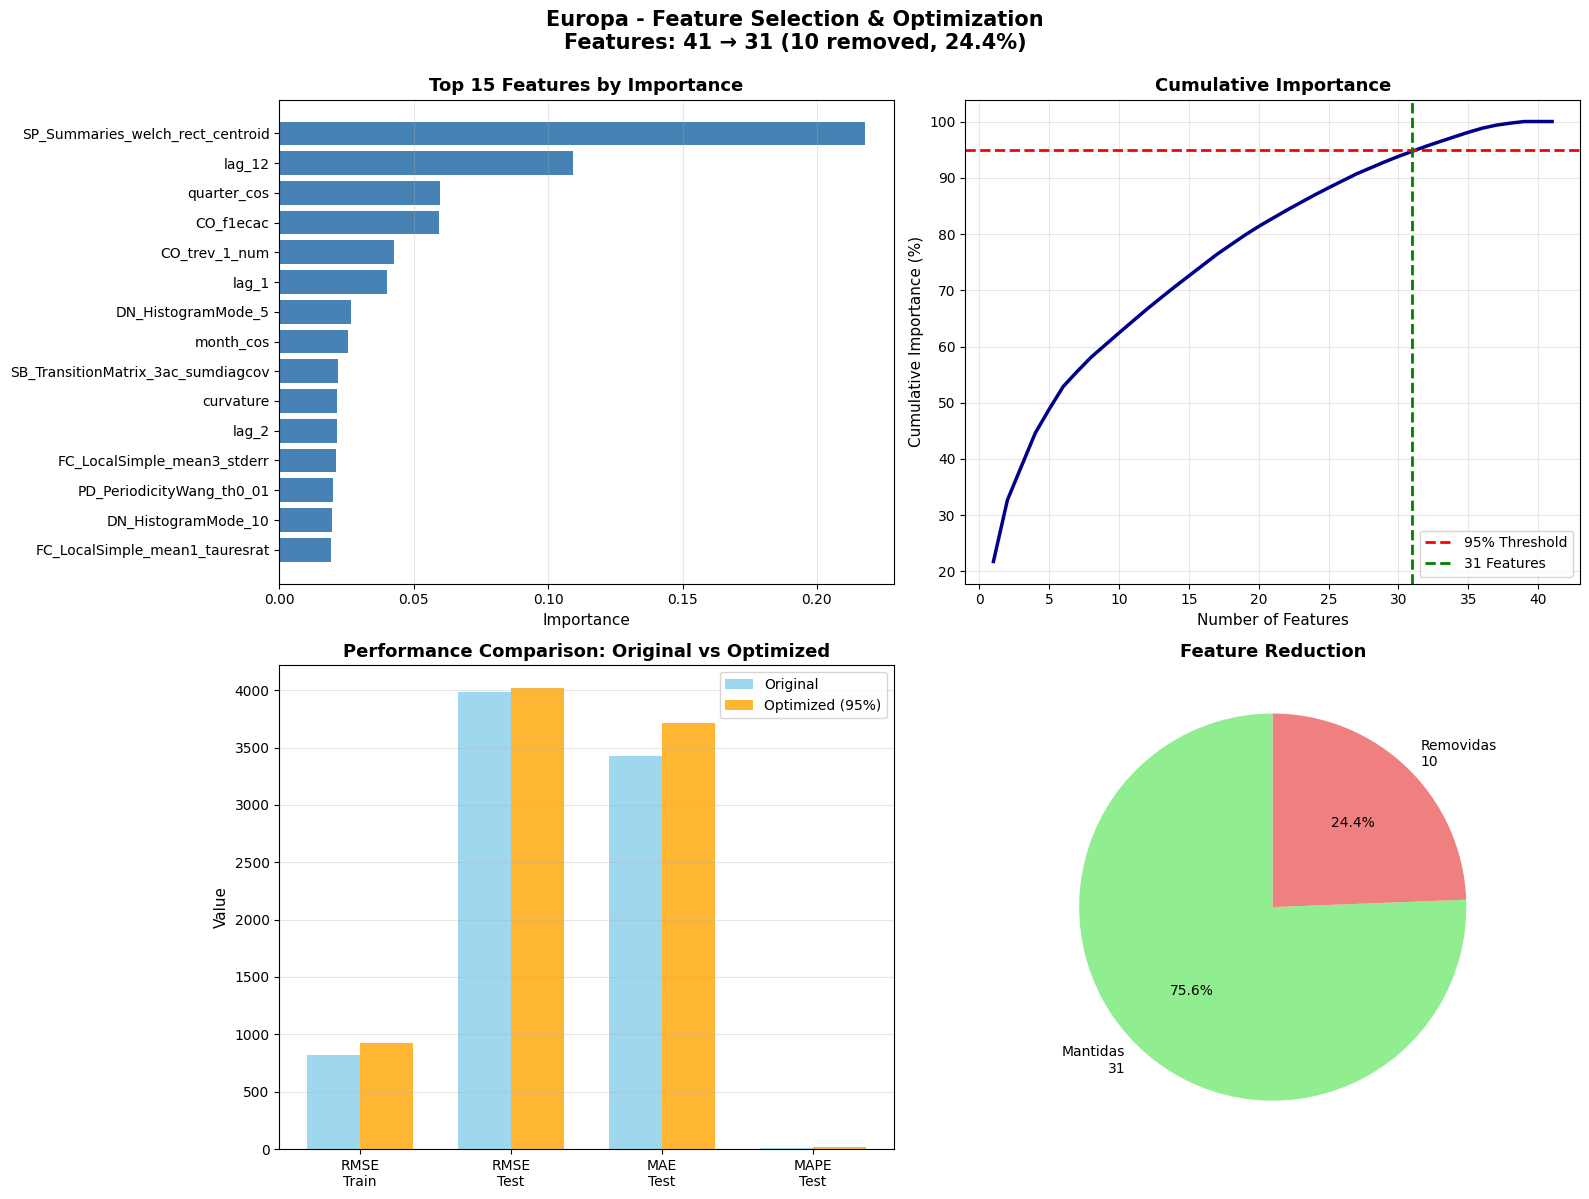


✓ Análise para Europa concluída!

SHAP ANALYSIS: OCEANIA

Features originais: 41

Calculando SHAP values...
⚠️ ERRO ao calcular SHAP: could not convert string to float: '[1.2252615E3]'
Tentando método alternativo...

--- Feature Selection (95% Importance) ---
Features selecionadas: 33 (80.5%)
Features removidas: 8 (19.5%)

Features REMOVIDAS (8):
  1. month_cos (Imp: 0.010314, Acum: 96.72%)
  2. seasonal_strength (Imp: 0.010644, Acum: 95.69%)
  3. seasonal_trough_year (Imp: 0.008014, Acum: 99.27%)
  4. PD_PeriodicityWang_th0_01 (Imp: 0.009471, Acum: 97.67%)
  5. DN_OutlierInclude_n_001_mdrmd (Imp: 0.008020, Acum: 98.47%)
  6. SB_MotifThree_quantile_hh (Imp: 0.007270, Acum: 100.00%)
  7. SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  8. SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)

Top 10 Features MANTIDAS:
  1. lag_1 (Imp: 0.082543, Acum: 8.25%)
  2. CO_f1ecac (Imp: 0.075101, Acum: 15.76%)
  3. SP_Summaries_welch_rect_centroid (Im

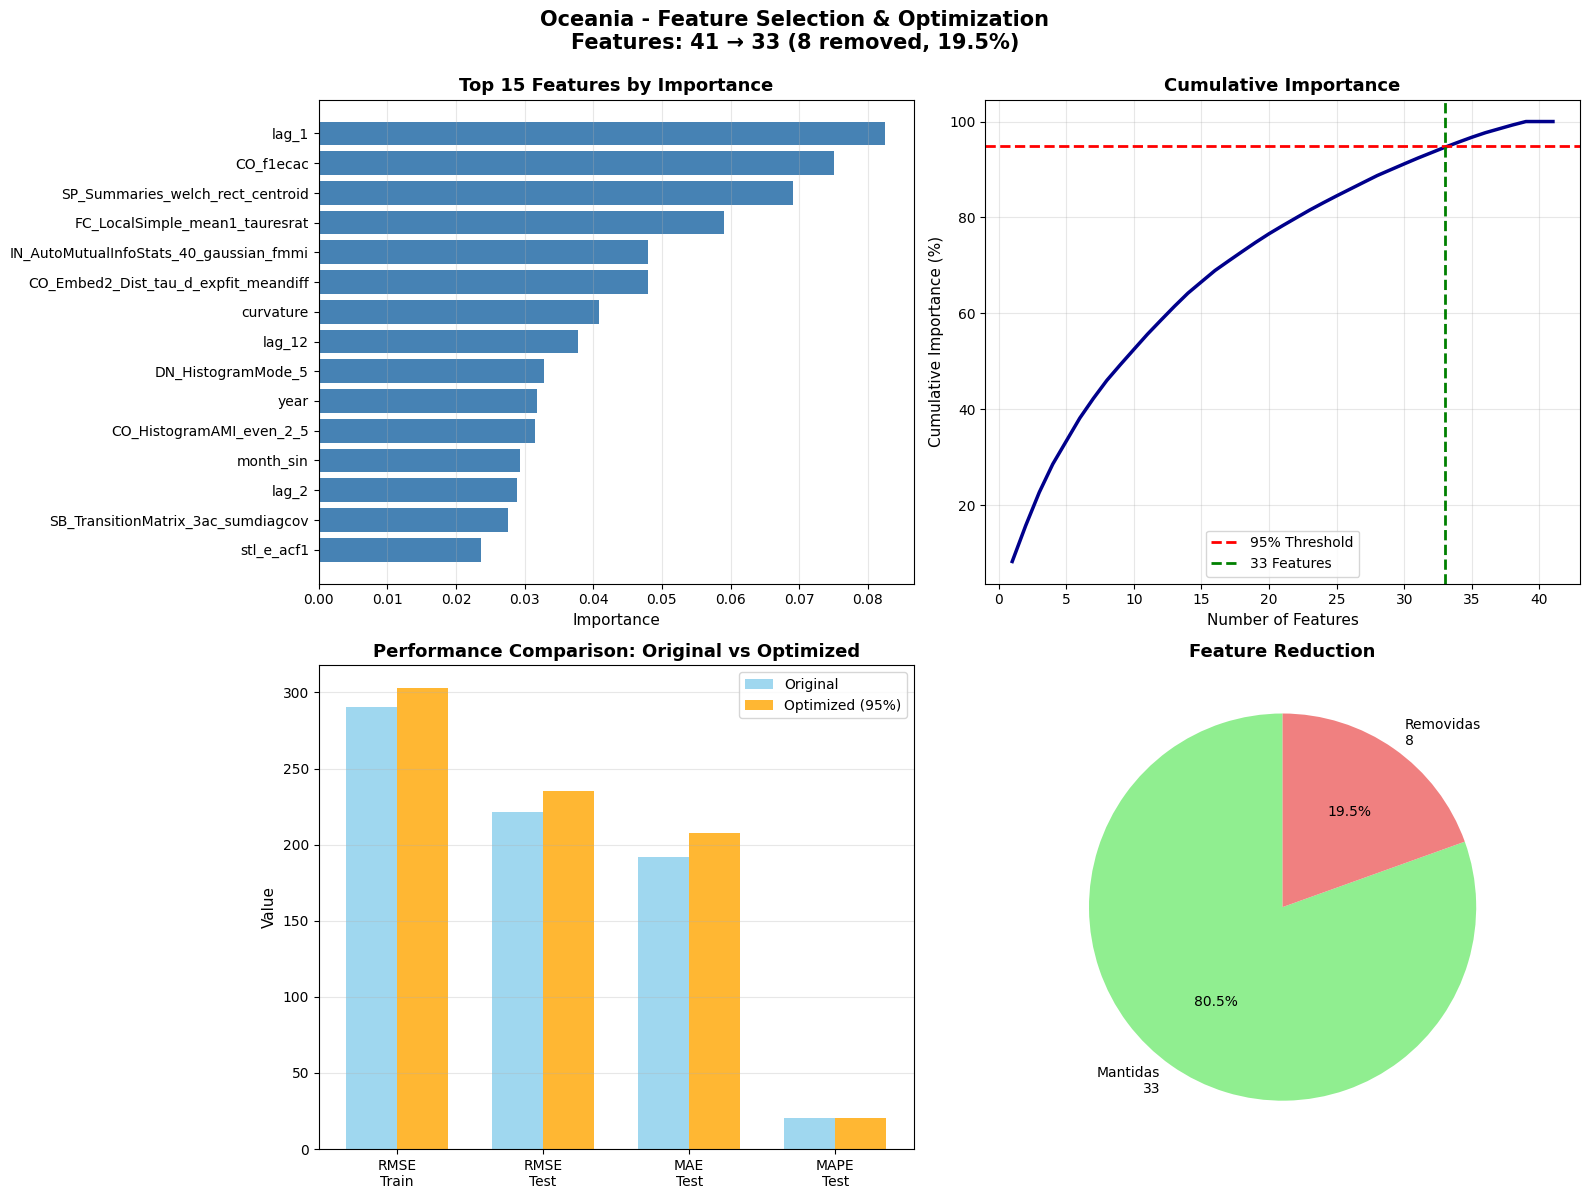


✓ Análise para Oceania concluída!

SHAP ANALYSIS: TOTAL

Features originais: 41

Calculando SHAP values...
⚠️ ERRO ao calcular SHAP: could not convert string to float: '[8.864488E4]'
Tentando método alternativo...

--- Feature Selection (95% Importance) ---
Features selecionadas: 31 (75.6%)
Features removidas: 10 (24.4%)

Features REMOVIDAS (10):
  1. seasonal_strength (Imp: 0.009641, Acum: 97.78%)
  2. seasonal_trough_year (Imp: 0.010005, Acum: 95.84%)
  3. linearity (Imp: 0.000000, Acum: 100.00%)
  4. DN_HistogramMode_10 (Imp: 0.009119, Acum: 98.69%)
  5. MD_hrv_classic_pnn40 (Imp: 0.008927, Acum: 99.58%)
  6. SB_BinaryStats_mean_longstretch1 (Imp: 0.004192, Acum: 100.00%)
  7. SB_TransitionMatrix_3ac_sumdiagcov (Imp: 0.009711, Acum: 96.81%)
  8. SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  9. SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  10. SP_Summaries_welch_rect_centroid (Imp: 0.000000, Acum: 100.00%)

Top 10 Features MAN

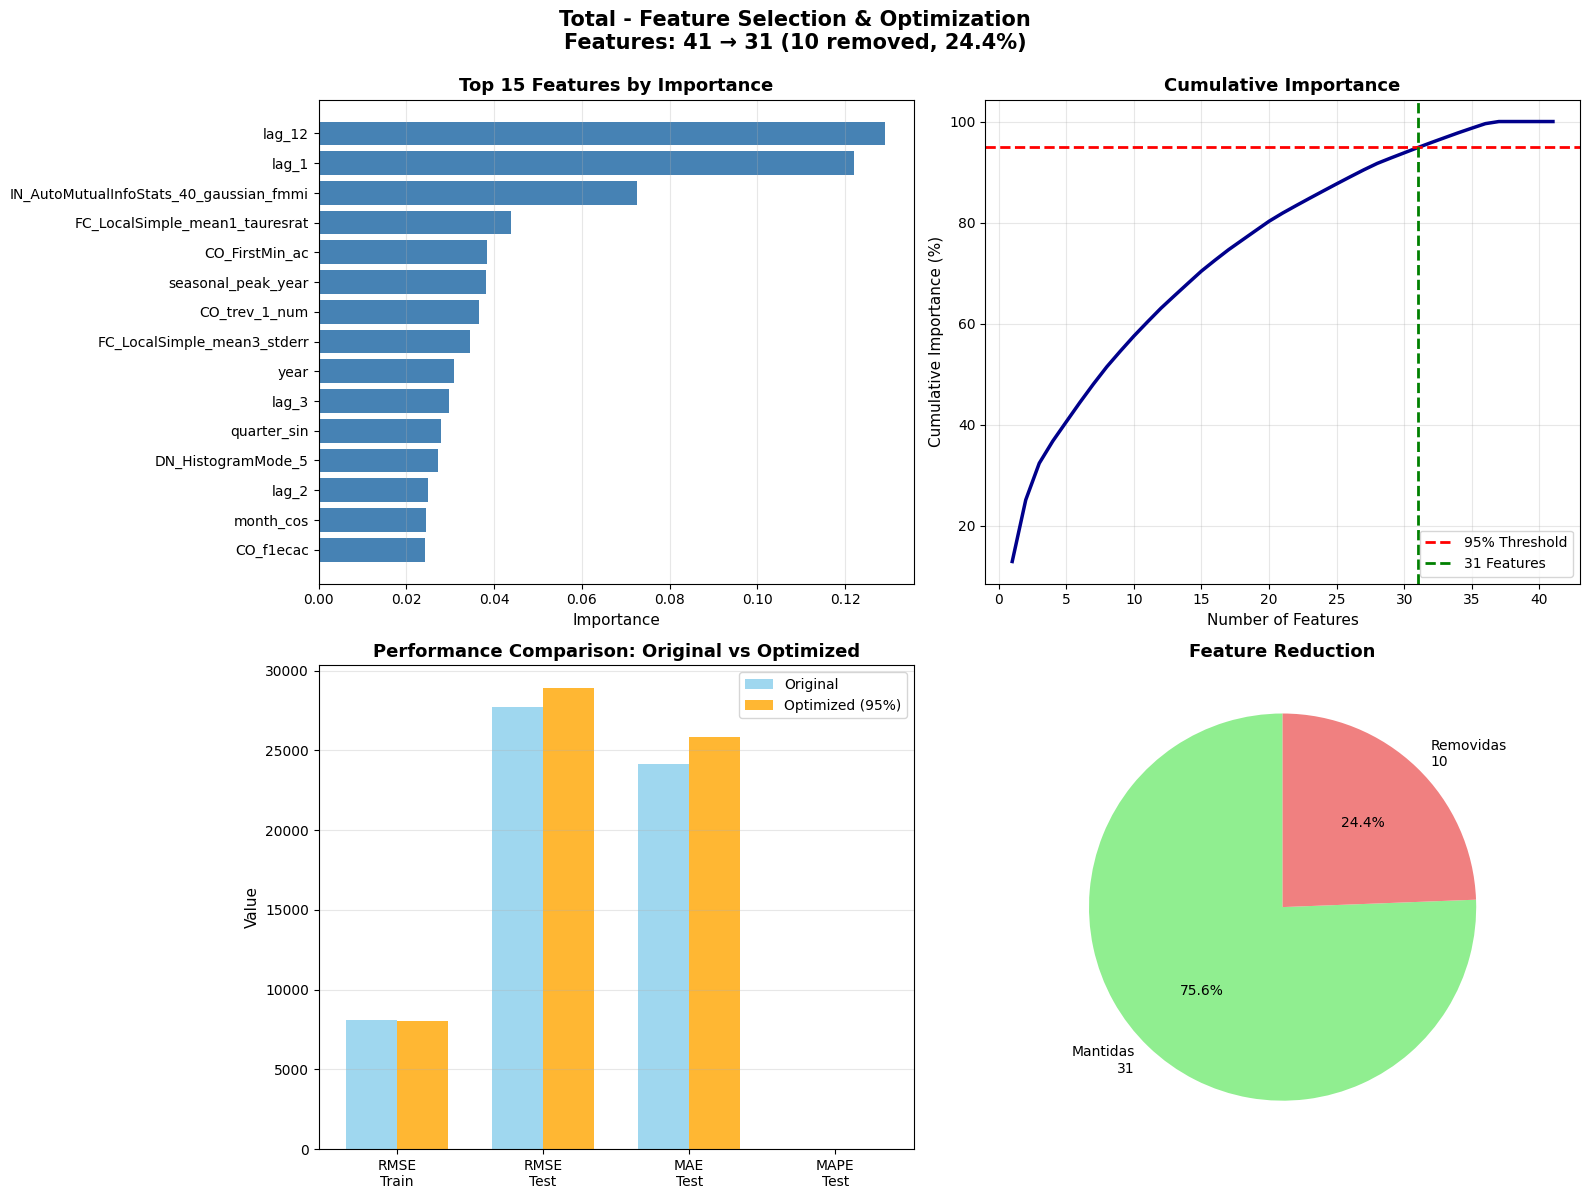


✓ Análise para TOTAL concluída!

RESUMO CONSOLIDADO - FEATURE SELECTION

--- Redução de Features ---
               Continent  Features_Original  Features_Selected  Features_Removed  Reduction_Pct
                  Africa                 41                 33                 8      19.512195
America_Central_E_Caribe                 41                 30                11      26.829268
        America_Do_Norte                 41                 31                10      24.390244
          America_Do_Sul                 41                 24                17      41.463415
                    Asia                 41                 31                10      24.390244
                  Europa                 41                 31                10      24.390244
                 Oceania                 41                 33                 8      19.512195
                   TOTAL                 41                 31                10      24.390244

--- Impacto no Test RMSE ---
    

In [56]:
import shap
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("ANÁLISE SHAP E SELEÇÃO DE FEATURES - TOP 95%")
print("="*80 + "\n")

# ========================================
# ANÁLISE SHAP POR CONTINENTE
# ========================================
shap_results = []
optimized_models = {}

for continent in continents:
    if continent not in xgb_models:
        continue
    
    print(f"\n{'='*80}")
    print(f"SHAP ANALYSIS: {continent.upper()}")
    print(f"{'='*80}\n")
    
    # Carregar modelo e dados
    model_data = xgb_models[continent]
    best_model = model_data['model']
    train_data = model_data['train_data']
    test_data = model_data['test_data']
    feature_cols = model_data['feature_cols']
    
    X_train = train_data[feature_cols]
    y_train = train_data['arrivals']
    X_test = test_data[feature_cols]
    y_test = test_data['arrivals']
    
    print(f"Features originais: {len(feature_cols)}")
    
    # ========================================
    # CALCULAR SHAP VALUES
    # ========================================
    print("\nCalculando SHAP values...")
    
    # ✅ FIX: Usar TreeExplainer com model_output='raw'
    try:
        explainer = shap.TreeExplainer(best_model, X_train, model_output='raw')
        shap_values = explainer.shap_values(X_train)
    except Exception as e:
        print(f"⚠️ ERRO ao calcular SHAP: {e}")
        print("Tentando método alternativo...")
        
        # Fallback: usar feature_importances_ do XGBoost
        shap_importance = best_model.feature_importances_
        
        shap_df = pd.DataFrame({
            'feature': feature_cols,
            'shap_importance': shap_importance
        }).sort_values('shap_importance', ascending=False).reset_index(drop=True)
        
        shap_df['cumulative_importance'] = shap_df['shap_importance'].cumsum() / shap_df['shap_importance'].sum() * 100
        
        shap_values = None  # Flag para pular visualização SHAP
        
    # Se SHAP funcionou, calcular importância
    if shap_values is not None:
        # Feature importance baseada em SHAP (média absoluta)
        shap_importance = np.abs(shap_values).mean(axis=0)
        
        # Criar DataFrame de importância
        shap_df = pd.DataFrame({
            'feature': feature_cols,
            'shap_importance': shap_importance
        }).sort_values('shap_importance', ascending=False).reset_index(drop=True)
        
        # Calcular importância acumulada
        shap_df['cumulative_importance'] = shap_df['shap_importance'].cumsum() / shap_df['shap_importance'].sum() * 100
    
    # ========================================
    # SELECIONAR FEATURES TOP 95%
    # ========================================
    features_95 = shap_df[shap_df['cumulative_importance'] <= 95].copy()
    selected_features = features_95['feature'].tolist()
    
    removed_features = [f for f in feature_cols if f not in selected_features]
    
    print(f"\n--- Feature Selection (95% Importance) ---")
    print(f"Features selecionadas: {len(selected_features)} ({len(selected_features)/len(feature_cols)*100:.1f}%)")
    print(f"Features removidas: {len(removed_features)} ({len(removed_features)/len(feature_cols)*100:.1f}%)")
    
    if len(removed_features) > 0:
        print(f"\nFeatures REMOVIDAS ({len(removed_features)}):")
        for i, feat in enumerate(removed_features[:10], 1):  # Mostrar apenas top 10
            feat_data = shap_df[shap_df['feature'] == feat].iloc[0]
            print(f"  {i}. {feat} (Imp: {feat_data['shap_importance']:.6f}, Acum: {feat_data['cumulative_importance']:.2f}%)")
        
        if len(removed_features) > 10:
            print(f"  ... e mais {len(removed_features) - 10} features")
    
    print(f"\nTop 10 Features MANTIDAS:")
    for i, (_, row) in enumerate(features_95.head(10).iterrows(), 1):
        print(f"  {i}. {row['feature']} (Imp: {row['shap_importance']:.6f}, Acum: {row['cumulative_importance']:.2f}%)")
    
    # ========================================
    # RETREINAR MODELO COM FEATURES SELECIONADAS
    # ========================================
    print(f"\nRetreinando modelo com {len(selected_features)} features...")
    
    # Pegar melhores parâmetros do grid search
    result = results_df[results_df['Continent'] == continent].iloc[0]
    
    best_params = {
        'n_estimators': int(result['n_estimators']),
        'learning_rate': result['learning_rate'],
        'max_depth': int(result['max_depth']),
        'min_child_weight': int(result['min_child_weight']),
        'subsample': result['subsample'],
        'colsample_bytree': result['colsample_bytree'],
        'random_state': 42,
        'verbosity': 0
    }
    
    # Treinar modelo otimizado
    X_train_opt = X_train[selected_features]
    X_test_opt = X_test[selected_features]
    
    import xgboost as xgb
    model_optimized = xgb.XGBRegressor(**best_params)
    model_optimized.fit(X_train_opt, y_train)
    
    # Predições
    y_pred_train_opt = model_optimized.predict(X_train_opt)
    y_pred_test_opt = model_optimized.predict(X_test_opt)
    
    # ========================================
    # COMPARAÇÃO DE RESULTADOS
    # ========================================
    # Modelo ORIGINAL (todas features)
    y_pred_train_orig = best_model.predict(X_train)
    y_pred_test_orig = best_model.predict(X_test)
    
    # Métricas ORIGINAL
    rmse_train_orig = np.sqrt(mean_squared_error(y_train, y_pred_train_orig))
    rmse_test_orig = np.sqrt(mean_squared_error(y_test, y_pred_test_orig))
    mae_train_orig = mean_absolute_error(y_train, y_pred_train_orig)
    mae_test_orig = mean_absolute_error(y_test, y_pred_test_orig)
    
    mask_train = y_train > 0
    mask_test = y_test > 0
    mape_train_orig = np.mean(np.abs((y_train[mask_train] - y_pred_train_orig[mask_train]) / y_train[mask_train])) * 100 if mask_train.sum() > 0 else np.nan
    mape_test_orig = np.mean(np.abs((y_test[mask_test] - y_pred_test_orig[mask_test]) / y_test[mask_test])) * 100 if mask_test.sum() > 0 else np.nan
    
    # Métricas OTIMIZADO
    rmse_train_opt = np.sqrt(mean_squared_error(y_train, y_pred_train_opt))
    rmse_test_opt = np.sqrt(mean_squared_error(y_test, y_pred_test_opt))
    mae_train_opt = mean_absolute_error(y_train, y_pred_train_opt)
    mae_test_opt = mean_absolute_error(y_test, y_pred_test_opt)
    
    mape_train_opt = np.mean(np.abs((y_train[mask_train] - y_pred_train_opt[mask_train]) / y_train[mask_train])) * 100 if mask_train.sum() > 0 else np.nan
    mape_test_opt = np.mean(np.abs((y_test[mask_test] - y_pred_test_opt[mask_test]) / y_test[mask_test])) * 100 if mask_test.sum() > 0 else np.nan
    
    # Diferenças
    delta_rmse_train = rmse_train_opt - rmse_train_orig
    delta_rmse_test = rmse_test_opt - rmse_test_orig
    delta_mae_train = mae_train_opt - mae_train_orig
    delta_mae_test = mae_test_opt - mae_test_orig
    delta_mape_train = mape_train_opt - mape_train_orig
    delta_mape_test = mape_test_opt - mape_test_orig
    
    print(f"\n{'='*60}")
    print(f"COMPARAÇÃO: ORIGINAL vs OTIMIZADO (95%)")
    print(f"{'='*60}")
    
    print(f"\n{'Métrica':<15} {'Original':<12} {'Otimizado':<12} {'Delta':<12} {'%':<10}")
    print("-" * 60)
    
    # TRAIN
    print(f"TRAIN RMSE:     {rmse_train_orig:<12.2f} {rmse_train_opt:<12.2f} {delta_rmse_train:<12.2f} {delta_rmse_train/rmse_train_orig*100:>8.2f}%")
    print(f"TRAIN MAE:      {mae_train_orig:<12.2f} {mae_train_opt:<12.2f} {delta_mae_train:<12.2f} {delta_mae_train/mae_train_orig*100:>8.2f}%")
    print(f"TRAIN MAPE:     {mape_train_orig:<12.2f} {mape_train_opt:<12.2f} {delta_mape_train:<12.2f} {delta_mape_train/mape_train_orig*100:>8.2f}%")
    
    print("-" * 60)
    
    # TEST
    print(f"TEST RMSE:      {rmse_test_orig:<12.2f} {rmse_test_opt:<12.2f} {delta_rmse_test:<12.2f} {delta_rmse_test/rmse_test_orig*100:>8.2f}%")
    print(f"TEST MAE:       {mae_test_orig:<12.2f} {mae_test_opt:<12.2f} {delta_mae_test:<12.2f} {delta_mae_test/mae_test_orig*100:>8.2f}%")
    print(f"TEST MAPE:      {mape_test_orig:<12.2f} {mape_test_opt:<12.2f} {delta_mape_test:<12.2f} {delta_mape_test/mape_test_orig*100:>8.2f}%")
    
    print("-" * 60)
    
    # GAP
    gap_orig = abs(rmse_train_orig - rmse_test_orig)
    gap_opt = abs(rmse_train_opt - rmse_test_opt)
    delta_gap = gap_opt - gap_orig
    
    print(f"GAP (|Tr-Te|):  {gap_orig:<12.2f} {gap_opt:<12.2f} {delta_gap:<12.2f} {delta_gap/gap_orig*100:>8.2f}%")
    
    # Interpretação
    print(f"\n--- Interpretação ---")
    
    if delta_rmse_test < 0:
        print(f"✓ MELHORIA: Test RMSE reduziu {abs(delta_rmse_test):.2f} ({abs(delta_rmse_test/rmse_test_orig*100):.2f}%)")
    elif delta_rmse_test > 0:
        print(f"⚠️ PIORA: Test RMSE aumentou {delta_rmse_test:.2f} ({delta_rmse_test/rmse_test_orig*100:.2f}%)")
    else:
        print(f"= NEUTRO: Test RMSE manteve-se igual")
    
    if abs(delta_rmse_test / rmse_test_orig * 100) < 1:
        print(f"  → Mudança INSIGNIFICANTE (< 1%)")
        impact = "Insignificant"
    elif abs(delta_rmse_test / rmse_test_orig * 100) < 5:
        print(f"  → Mudança MODERADA (1-5%)")
        impact = "Moderate"
    else:
        print(f"  → Mudança SIGNIFICATIVA (> 5%)")
        impact = "Significant"
    
    # ========================================
    # ARMAZENAR RESULTADOS
    # ========================================
    shap_results.append({
        'Continent': continent,
        'Features_Original': len(feature_cols),
        'Features_Selected': len(selected_features),
        'Features_Removed': len(removed_features),
        'Reduction_Pct': len(removed_features) / len(feature_cols) * 100,
        'RMSE_Train_Orig': rmse_train_orig,
        'RMSE_Train_Opt': rmse_train_opt,
        'RMSE_Test_Orig': rmse_test_orig,
        'RMSE_Test_Opt': rmse_test_opt,
        'Delta_RMSE_Train': delta_rmse_train,
        'Delta_RMSE_Test': delta_rmse_test,
        'Delta_RMSE_Test_Pct': delta_rmse_test / rmse_test_orig * 100,
        'MAE_Test_Orig': mae_test_orig,
        'MAE_Test_Opt': mae_test_opt,
        'MAPE_Test_Orig': mape_test_orig,
        'MAPE_Test_Opt': mape_test_opt,
        'GAP_Orig': gap_orig,
        'GAP_Opt': gap_opt,
        'Impact': impact
    })
    
    optimized_models[continent] = {
        'model': model_optimized,
        'selected_features': selected_features,
        'removed_features': removed_features,
        'shap_df': shap_df,
        'train_data': train_data,
        'test_data': test_data,
        'y_pred_train': y_pred_train_opt,
        'y_pred_test': y_pred_test_opt
    }
    
    # ========================================
    # VISUALIZAÇÃO (SEM SHAP PLOTS)
    # ========================================
    print(f"\nGerando visualizações...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Feature Importance (bar)
    axes[0, 0].barh(range(min(15, len(shap_df))), 
                    shap_df['shap_importance'].head(15)[::-1], 
                    color='steelblue')
    axes[0, 0].set_yticks(range(min(15, len(shap_df))))
    axes[0, 0].set_yticklabels(shap_df['feature'].head(15)[::-1])
    axes[0, 0].set_xlabel('Importance', fontsize=11)
    axes[0, 0].set_title('Top 15 Features by Importance', 
                         fontsize=13, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='x')
    
    # Plot 2: Cumulative Importance
    axes[0, 1].plot(range(1, len(shap_df) + 1), 
                    shap_df['cumulative_importance'], 
                    linewidth=2.5, color='darkblue')
    axes[0, 1].axhline(y=95, color='red', linestyle='--', 
                       linewidth=2, label='95% Threshold')
    axes[0, 1].axvline(x=len(selected_features), color='green', 
                       linestyle='--', linewidth=2, 
                       label=f'{len(selected_features)} Features')
    axes[0, 1].set_xlabel('Number of Features', fontsize=11)
    axes[0, 1].set_ylabel('Cumulative Importance (%)', fontsize=11)
    axes[0, 1].set_title('Cumulative Importance', 
                         fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Performance Comparison
    metrics = ['RMSE\nTrain', 'RMSE\nTest', 'MAE\nTest', 'MAPE\nTest']
    orig_values = [rmse_train_orig, rmse_test_orig, mae_test_orig, mape_test_orig]
    opt_values = [rmse_train_opt, rmse_test_opt, mae_test_opt, mape_test_opt]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    axes[1, 0].bar(x - width/2, orig_values, width, label='Original', 
                   color='skyblue', alpha=0.8)
    axes[1, 0].bar(x + width/2, opt_values, width, label='Optimized (95%)', 
                   color='orange', alpha=0.8)
    
    axes[1, 0].set_ylabel('Value', fontsize=11)
    axes[1, 0].set_title('Performance Comparison: Original vs Optimized', 
                         fontsize=13, fontweight='bold')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(metrics)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Feature Reduction Pie Chart
    axes[1, 1].pie([len(selected_features), len(removed_features)],
                   labels=[f'Mantidas\n{len(selected_features)}', 
                          f'Removidas\n{len(removed_features)}'],
                   autopct='%1.1f%%',
                   colors=['lightgreen', 'lightcoral'],
                   startangle=90)
    axes[1, 1].set_title('Feature Reduction', 
                         fontsize=13, fontweight='bold')
    
    plt.suptitle(f'{continent.title()} - Feature Selection & Optimization\n' +
                 f'Features: {len(feature_cols)} → {len(selected_features)} ' +
                 f'({len(removed_features)} removed, {len(removed_features)/len(feature_cols)*100:.1f}%)',
                 fontsize=15, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Análise para {continent} concluída!")


# ========================================
# RESUMO CONSOLIDADO
# ========================================
print("\n" + "="*80)
print("RESUMO CONSOLIDADO - FEATURE SELECTION")
print("="*80 + "\n")

shap_summary_df = pd.DataFrame(shap_results)

print("--- Redução de Features ---")
print(shap_summary_df[['Continent', 'Features_Original', 'Features_Selected', 
                       'Features_Removed', 'Reduction_Pct']].to_string(index=False))

print("\n--- Impacto no Test RMSE ---")
print(shap_summary_df[['Continent', 'RMSE_Test_Orig', 'RMSE_Test_Opt', 
                       'Delta_RMSE_Test', 'Delta_RMSE_Test_Pct', 'Impact']].to_string(index=False))

print("\n--- Estatísticas Gerais ---")
print(f"Redução média de features: {shap_summary_df['Reduction_Pct'].mean():.2f}%")
print(f"Variação média Test RMSE: {shap_summary_df['Delta_RMSE_Test_Pct'].mean():.2f}%")

improved = (shap_summary_df['Delta_RMSE_Test'] < 0).sum()
worsened = (shap_summary_df['Delta_RMSE_Test'] > 0).sum()
neutral = (shap_summary_df['Delta_RMSE_Test'] == 0).sum()

print(f"\nContinentes com MELHORIA: {improved} ({improved/len(shap_summary_df)*100:.1f}%)")
print(f"Continentes com PIORA: {worsened} ({worsened/len(shap_summary_df)*100:.1f}%)")
print(f"Continentes NEUTROS: {neutral} ({neutral/len(shap_summary_df)*100:.1f}%)")

print("\n" + "="*80)
print("✓ ANÁLISE CONCLUÍDA")
print("="*80)

In [59]:
# ✅ CONSOLIDAR PREVISÕES DE TODOS OS CONTINENTES
all_forecasts = []

for continent in continents:
    if continent not in xgb_models:
        continue
    
    model_data = xgb_models[continent]
    test_data = model_data['test_data']
    y_pred_test = model_data['y_pred_test']
    
    continent_display = "TOTAL (Agregado)" if continent == 'TOTAL' else continent.title()
    
    # ✅ FIX: Calcular pct_error com numpy, depois substituir inf/nan
    actual = test_data['arrivals'].values
    forecast = y_pred_test
    pct_error = ((actual - forecast) / actual) * 100
    pct_error = np.where(np.isinf(pct_error) | np.isnan(pct_error), np.nan, pct_error)
    
    forecast_df = pd.DataFrame({
        'date': test_data['date'].values,
        'continent': continent_display,
        'actual': actual,
        'forecast': forecast,
        'error': actual - forecast,
        'abs_error': np.abs(actual - forecast),
        'pct_error': pct_error
    })
    
    all_forecasts.append(forecast_df)
    
    train_data = model_data['train_data']
    y_pred_train = model_data['y_pred_train']
    
    actual_train = train_data['arrivals'].values
    forecast_train = y_pred_train
    pct_error_train = ((actual_train - forecast_train) / actual_train) * 100
    pct_error_train = np.where(np.isinf(pct_error_train) | np.isnan(pct_error_train), np.nan, pct_error_train)
    
    train_forecast_df = pd.DataFrame({
        'date': train_data['date'].values,
        'continent': continent_display,
        'actual': actual_train,
        'forecast': forecast_train,
        'error': actual_train - forecast_train,
        'abs_error': np.abs(actual_train - forecast_train),
        'pct_error': pct_error_train
    })
    
    if 'all_train_forecasts' not in locals():
        all_train_forecasts = []
    
    all_train_forecasts.append(train_forecast_df)

# Consolidar
forecasts_final = pd.concat(all_forecasts, ignore_index=True)

print("="*80)
print("PREVISÕES CONSOLIDADAS - XGBOOST")
print("="*80)
print(f"Total de previsões: {len(forecasts_final)}")
print(f"Continentes: {forecasts_final['continent'].nunique()}")
print(f"Período: {forecasts_final['date'].min().strftime('%Y-%m')} a {forecasts_final['date'].max().strftime('%Y-%m')}")

display(forecasts_final.head(20))

# Salvar
output_path = PROJECT_ROOT / "notebooks" / "modeling" / "xgboost_forecasts_catch.csv"
forecasts_final.to_csv(output_path, index=False)
print(f"\n✓ Salvo em: {output_path}")

if 'all_train_forecasts' in locals() and len(all_train_forecasts) > 0:
    train_forecasts_final = pd.concat(all_train_forecasts, ignore_index=True)
    
    print("\n" + "="*80)
    print("PREVISÕES CONSOLIDADAS - XGBOOST (TREINO)")
    print("="*80)
    print(f"Total de fitted values: {len(train_forecasts_final)}")
    print(f"Continentes: {train_forecasts_final['continent'].nunique()}")
    print(f"Período: {train_forecasts_final['date'].min().strftime('%Y-%m')} a {train_forecasts_final['date'].max().strftime('%Y-%m')}")
    
    display(train_forecasts_final.head(20))
    
    output_path_train = PROJECT_ROOT / "notebooks" / "modeling" / "xgboost_forecasts_TRAIN_catch.csv"
    train_forecasts_final.to_csv(output_path_train, index=False)
    print(f"\n✓ Salvo em: {output_path_train}")

PREVISÕES CONSOLIDADAS - XGBOOST
Total de previsões: 96
Continentes: 8
Período: 2024-01 a 2024-12


date                 continent  actual     forecast       error  \
0  2024-01-01                    Africa   303.0   676.999878 -373.999878   
1  2024-02-01                    Africa   446.0   520.844727  -74.844727   
2  2024-03-01                    Africa   337.0   503.253998 -166.253998   
3  2024-04-01                    Africa   402.0   384.616364   17.383636   
4  2024-05-01                    Africa   397.0   387.794312    9.205688   
5  2024-06-01                    Africa   225.0   369.746765 -144.746765   
6  2024-07-01                    Africa   259.0   434.240601 -175.240601   
7  2024-08-01                    Africa   260.0   397.891998 -137.891998   
8  2024-09-01                    Africa   302.0   369.279236  -67.279236   
9  2024-10-01                    Africa   342.0   448.193146 -106.193146   
10 2024-11-01                    Africa   546.0   446.663849   99.336151   
11 2024-12-01                    Africa   439.0   659.637024 -220.637024   
12 2024-01-01  America_Central_E_Caribe   912.0  1123.303955 -211.303955   
13 2024-02-01  America_Central_E_Caribe   843.0   828.356995   14.643005   
14 2024-03-01  America_Central_E_Caribe  1302.0   850.570312  451.429688   
15 2024-04-01  America_Central_E_Caribe  1082.0  1242.494751 -160.494751   
16 2024-05-01  America_Central_E_Caribe  1155.0  1124.708740   30.291260   
17 2024-06-01  America_Central_E_Caribe  1293.0  1379.183105  -86.183105   
18 2024-07-01  America_Central_E_Caribe  1038.0  1585.776001 -547.776001   
19 2024-08-01  America_Central_E_Caribe  1337.0  1608.748291 -271.748291   

     abs_error   pct_error  
0   373.999878 -123.432303  
1    74.844727  -16.781329  
2   166.253998  -49.333531  
3    17.383636    4.324288  
4     9.205688    2.318813  
5   144.746765  -64.331896  
6   175.240601  -67.660464  
7   137.891998  -53.035384  
8    67.279236  -22.277893  
9   106.193146  -31.050627  
10   99.336151   18.193434  
11  220.637024  -50.259003  
12  211.303955  -23.169293  
13   14.643005    1.737011  
14  451.429688   34.672019  
15  160.494751  -14.833156  
16   30.291260    2.622620  
17   86.183105   -6.665360  
18  547.776001  -52.772254  
19  271.748291  -20.325227


✓ Salvo em: C:\Users\f0oo\OneDrive - PETROBRAS\Documentos\international_arrivals_time_series_forecasting\notebooks\modeling\xgboost_forecasts_catch.csv

PREVISÕES CONSOLIDADAS - XGBOOST (TREINO)
Total de fitted values: 10824
Continentes: 9
Período: 2002-01 a 2023-12


date continent  actual     forecast       error   abs_error  \
0  2002-01-01    Africa  1598.0  1597.139160    0.860840    0.860840   
1  2002-02-01    Africa  1479.0  1469.127319    9.872681    9.872681   
2  2002-03-01    Africa  1372.0  1353.363037   18.636963   18.636963   
3  2002-04-01    Africa  1046.0  1179.831055 -133.831055  133.831055   
4  2002-05-01    Africa  1101.0  1093.432129    7.567871    7.567871   
5  2002-06-01    Africa  1242.0  1199.344849   42.655151   42.655151   
6  2002-07-01    Africa  1579.0  1552.028442   26.971558   26.971558   
7  2002-08-01    Africa  1518.0  1482.136841   35.863159   35.863159   
8  2002-09-01    Africa  1293.0  1315.529541  -22.529541   22.529541   
9  2002-10-01    Africa  1254.0  1298.859863  -44.859863   44.859863   
10 2002-11-01    Africa  1286.0  1295.224976   -9.224976    9.224976   
11 2002-12-01    Africa  1552.0  1501.932129   50.067871   50.067871   
12 2003-01-01    Africa   876.0  1134.130493 -258.130493  258.130493   
13 2003-02-01    Africa   869.0   926.144104  -57.144104   57.144104   
14 2003-03-01    Africa   850.0  1015.304688 -165.304688  165.304688   
15 2003-04-01    Africa   812.0   832.527100  -20.527100   20.527100   
16 2003-05-01    Africa  1225.0  1088.334961  136.665039  136.665039   
17 2003-06-01    Africa   612.0   741.816650 -129.816650  129.816650   
18 2003-07-01    Africa   645.0   751.767334 -106.767334  106.767334   
19 2003-08-01    Africa  1404.0  1327.757935   76.242065   76.242065   

    pct_error  
0    0.053870  
1    0.667524  
2    1.358379  
3  -12.794556  
4    0.687363  
5    3.434392  
6    1.708142  
7    2.362527  
8   -1.742424  
9   -3.577342  
10  -0.717339  
11   3.226023  
12 -29.466951  
13  -6.575846  
14 -19.447610  
15  -2.527968  
16  11.156330  
17 -21.211871  
18 -16.553075  
19   5.430347


✓ Salvo em: C:\Users\f0oo\OneDrive - PETROBRAS\Documentos\international_arrivals_time_series_forecasting\notebooks\modeling\xgboost_forecasts_TRAIN_catch.csv


VISUALIZAÇÕES - XGBOOST RESULTADOS


Gerando gráficos para: Africa

--- Residual Diagnostics (Training Set) ---
Residual Mean: 1.3560
Residual Std: 117.49

T-Test for Zero Mean:
  t-statistic: 0.1872
  p-value: 0.8517
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (5.87)

Ljung-Box Test (lag 24):
  p-value: 0.0429
  ✗ FAIL: Significant autocorrelation detected (p < 0.05)

Jarque-Bera Test (Normality):
  Statistic: 1581.2472
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.9008
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


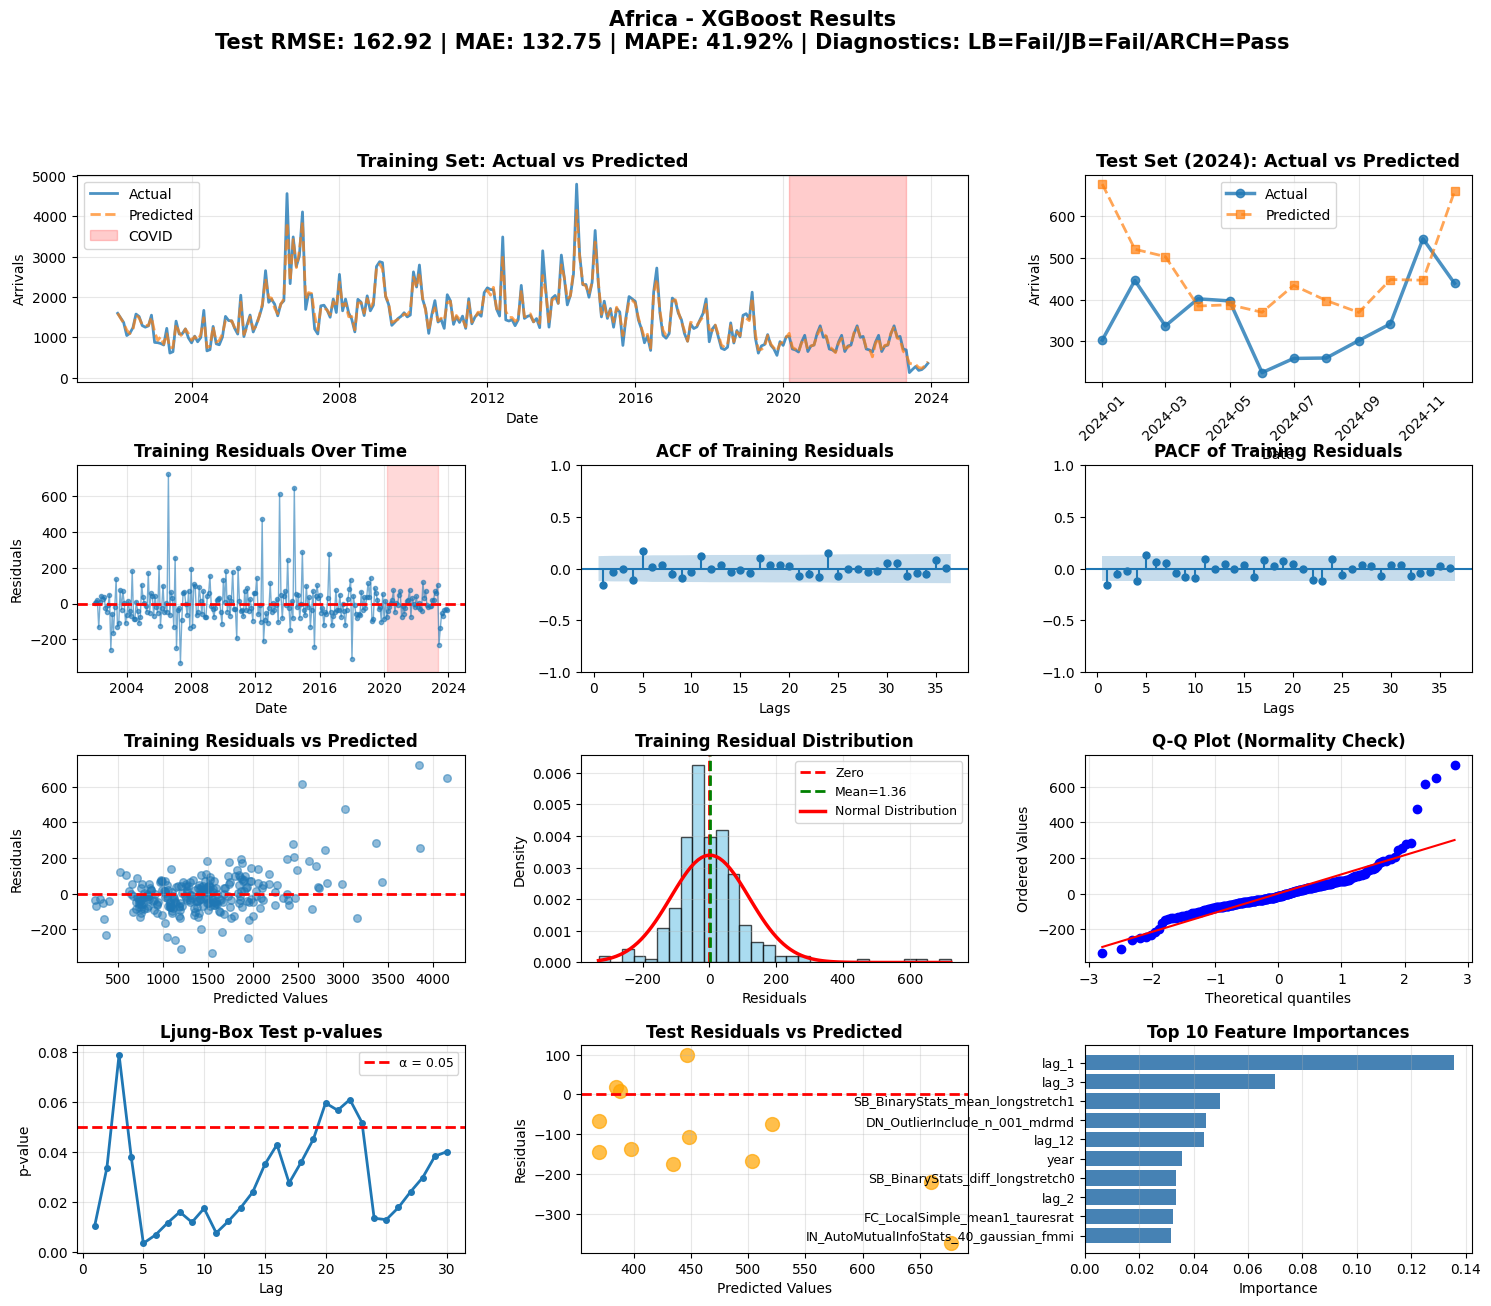


Gerando gráficos para: America_Central_E_Caribe

--- Residual Diagnostics (Training Set) ---
Residual Mean: -2.8879
Residual Std: 203.49

T-Test for Zero Mean:
  t-statistic: -0.2302
  p-value: 0.8181
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (10.17)

Ljung-Box Test (lag 24):
  p-value: 0.0001
  ✗ FAIL: Significant autocorrelation detected (p < 0.05)

Jarque-Bera Test (Normality):
  Statistic: 43796.4537
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.9996
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


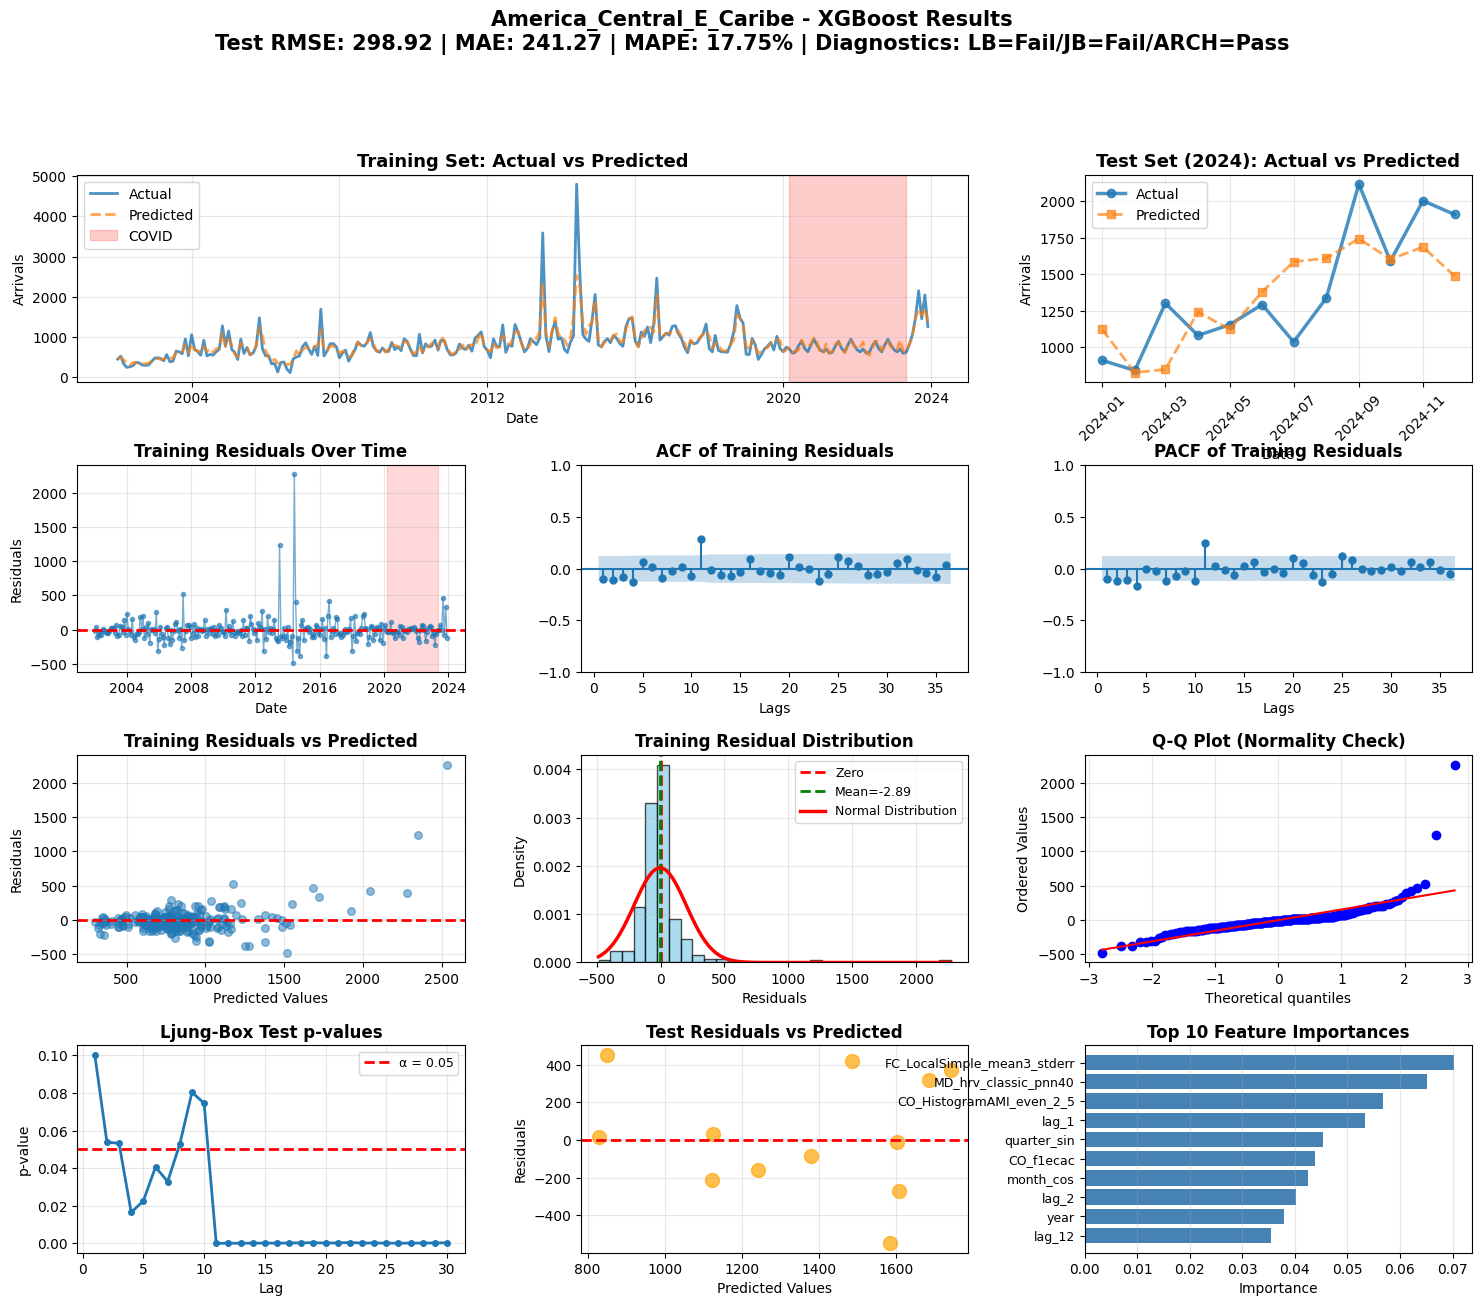


Gerando gráficos para: America_Do_Norte

--- Residual Diagnostics (Training Set) ---
Residual Mean: 11.8922
Residual Std: 1143.15

T-Test for Zero Mean:
  t-statistic: 0.1687
  p-value: 0.8662
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (57.16)

Ljung-Box Test (lag 24):
  p-value: 0.7909
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 19.7032
  p-value: 0.0001
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.2333
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


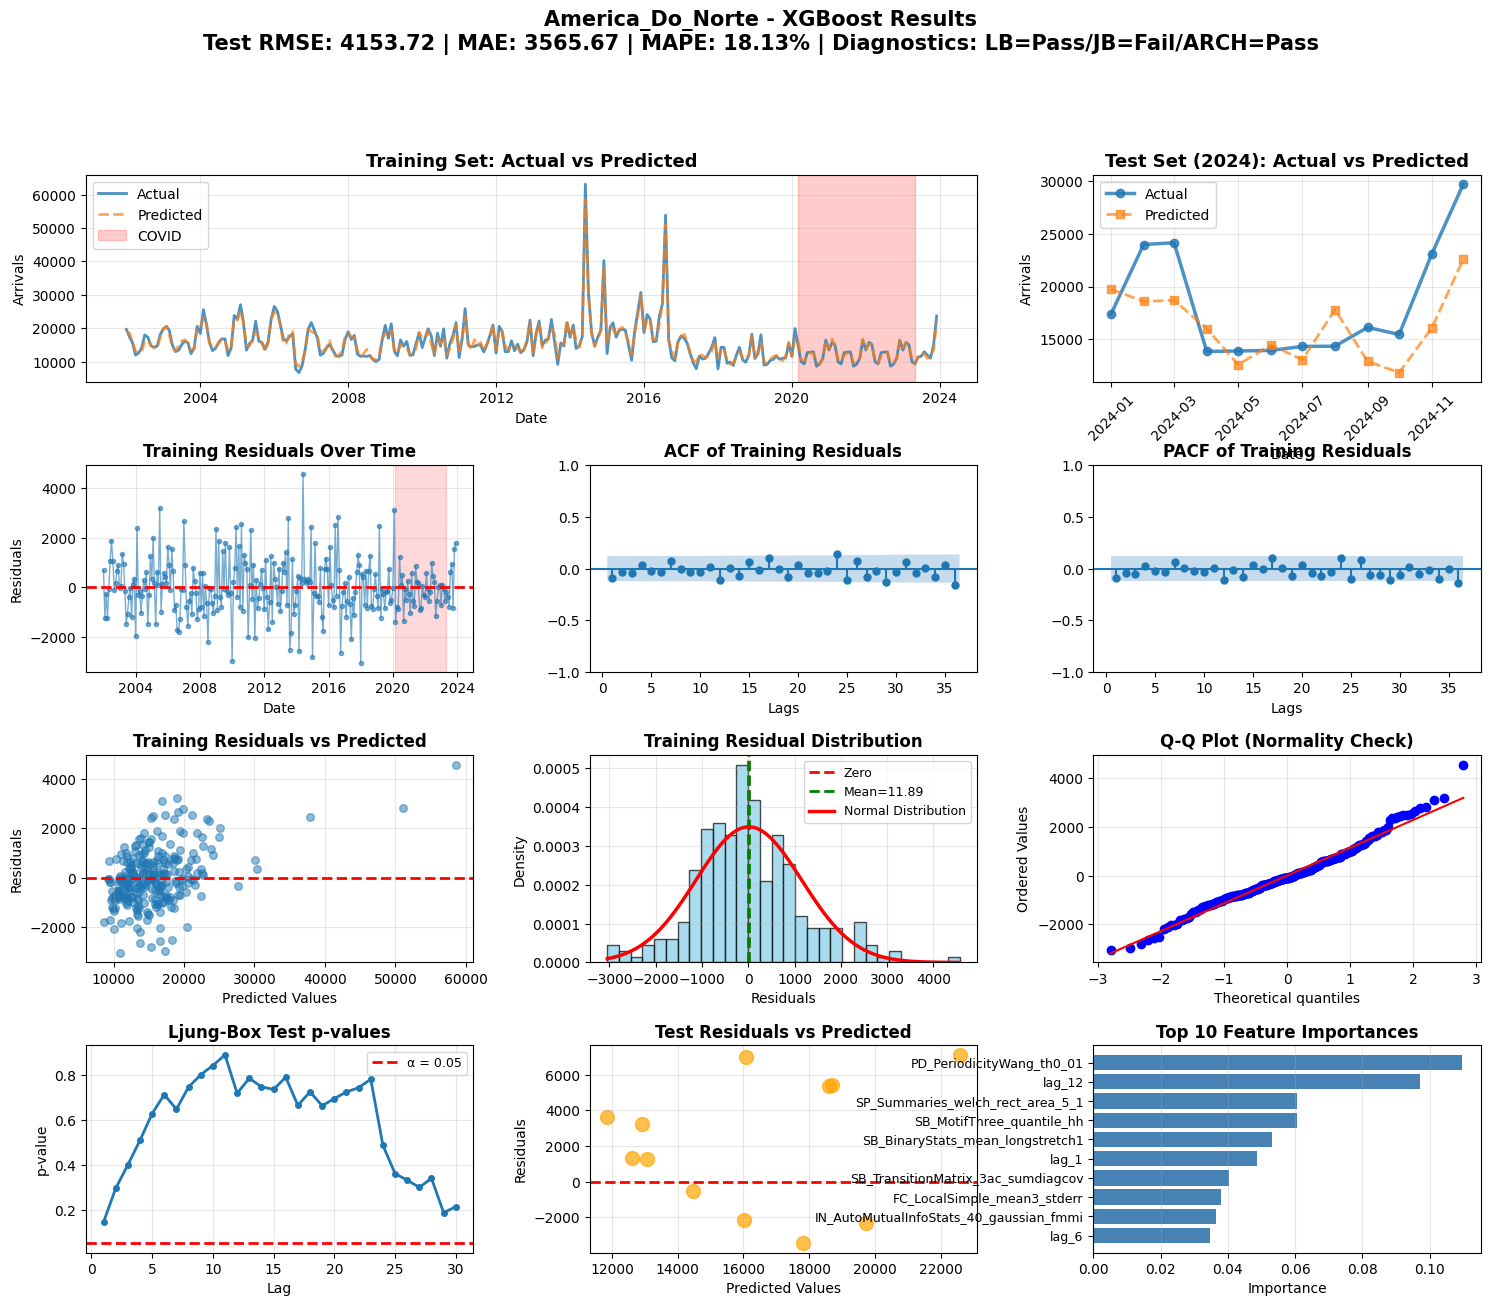


Gerando gráficos para: America_Do_Sul

--- Residual Diagnostics (Training Set) ---
Residual Mean: 3.7708
Residual Std: 904.48

T-Test for Zero Mean:
  t-statistic: 0.0676
  p-value: 0.9461
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (45.22)

Ljung-Box Test (lag 24):
  p-value: 0.0723
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 282.8678
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.9164
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


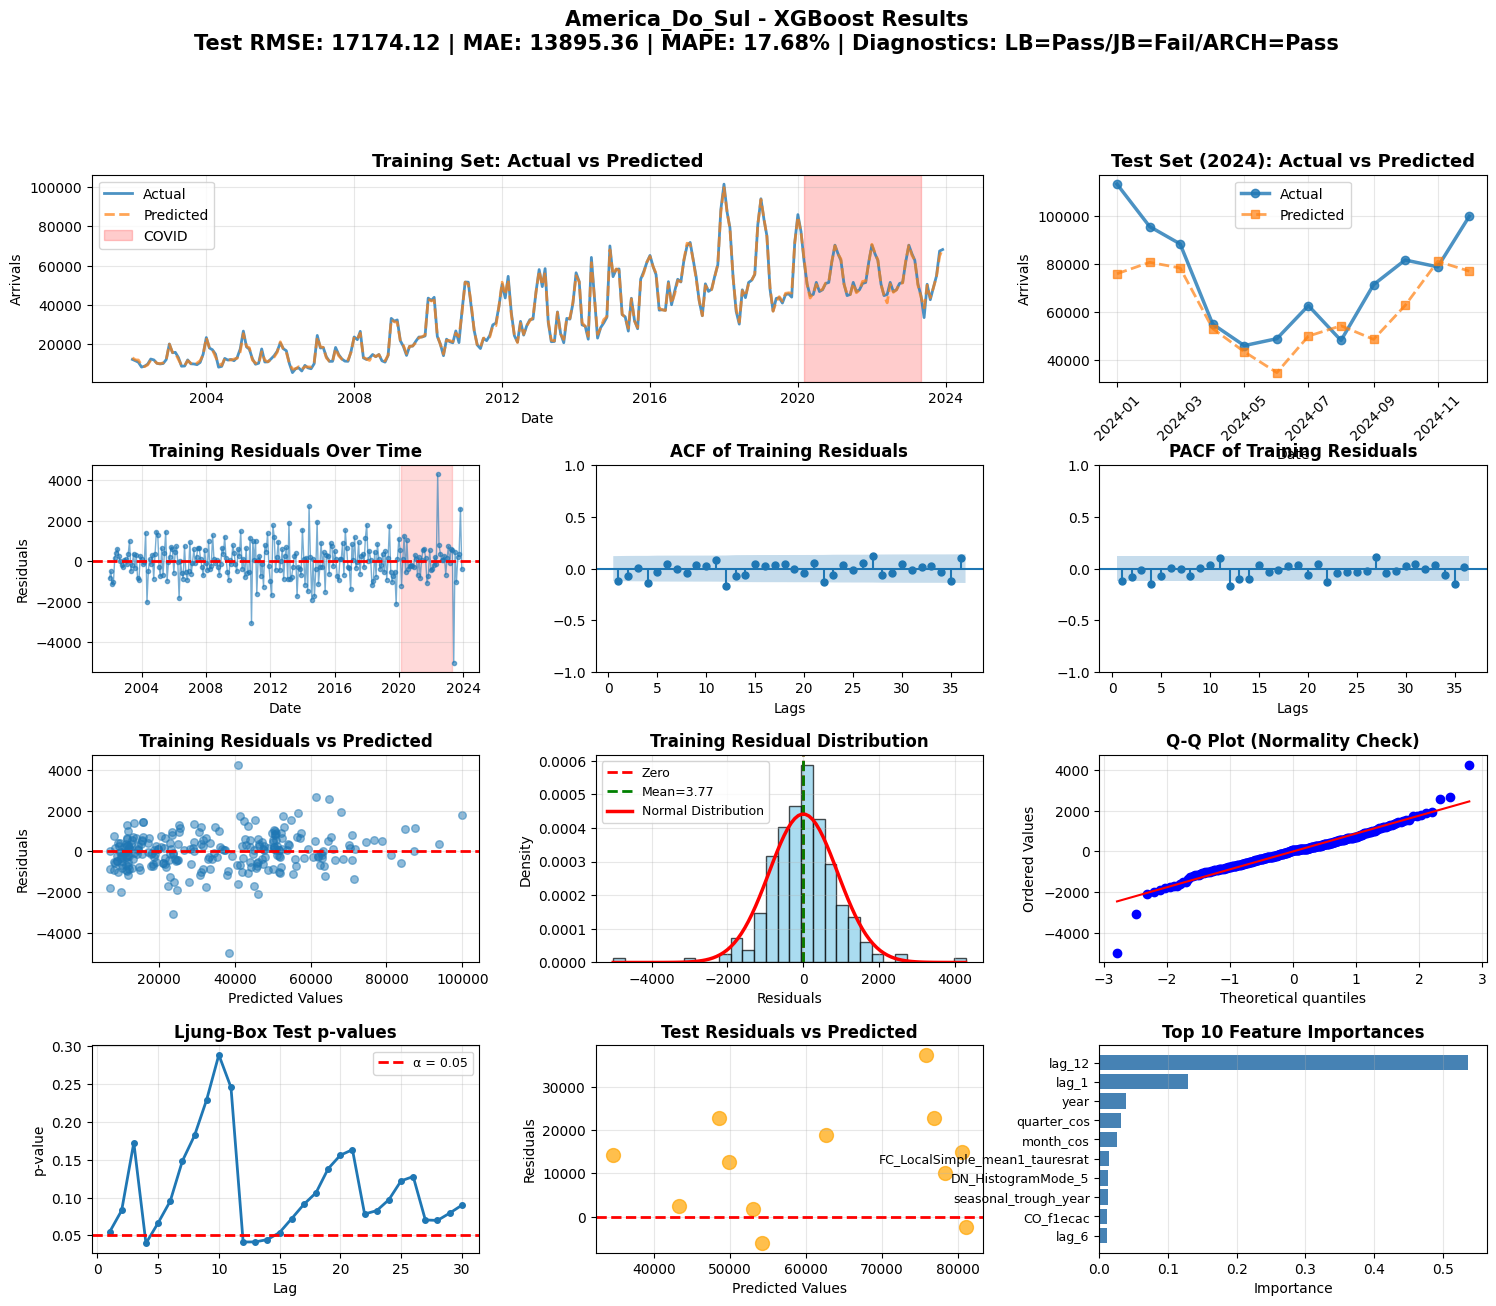


Gerando gráficos para: Asia

--- Residual Diagnostics (Training Set) ---
Residual Mean: -0.8099
Residual Std: 358.14

T-Test for Zero Mean:
  t-statistic: -0.0367
  p-value: 0.9708
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (17.91)

Ljung-Box Test (lag 24):
  p-value: 0.4992
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 18391.8728
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 1.0000
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


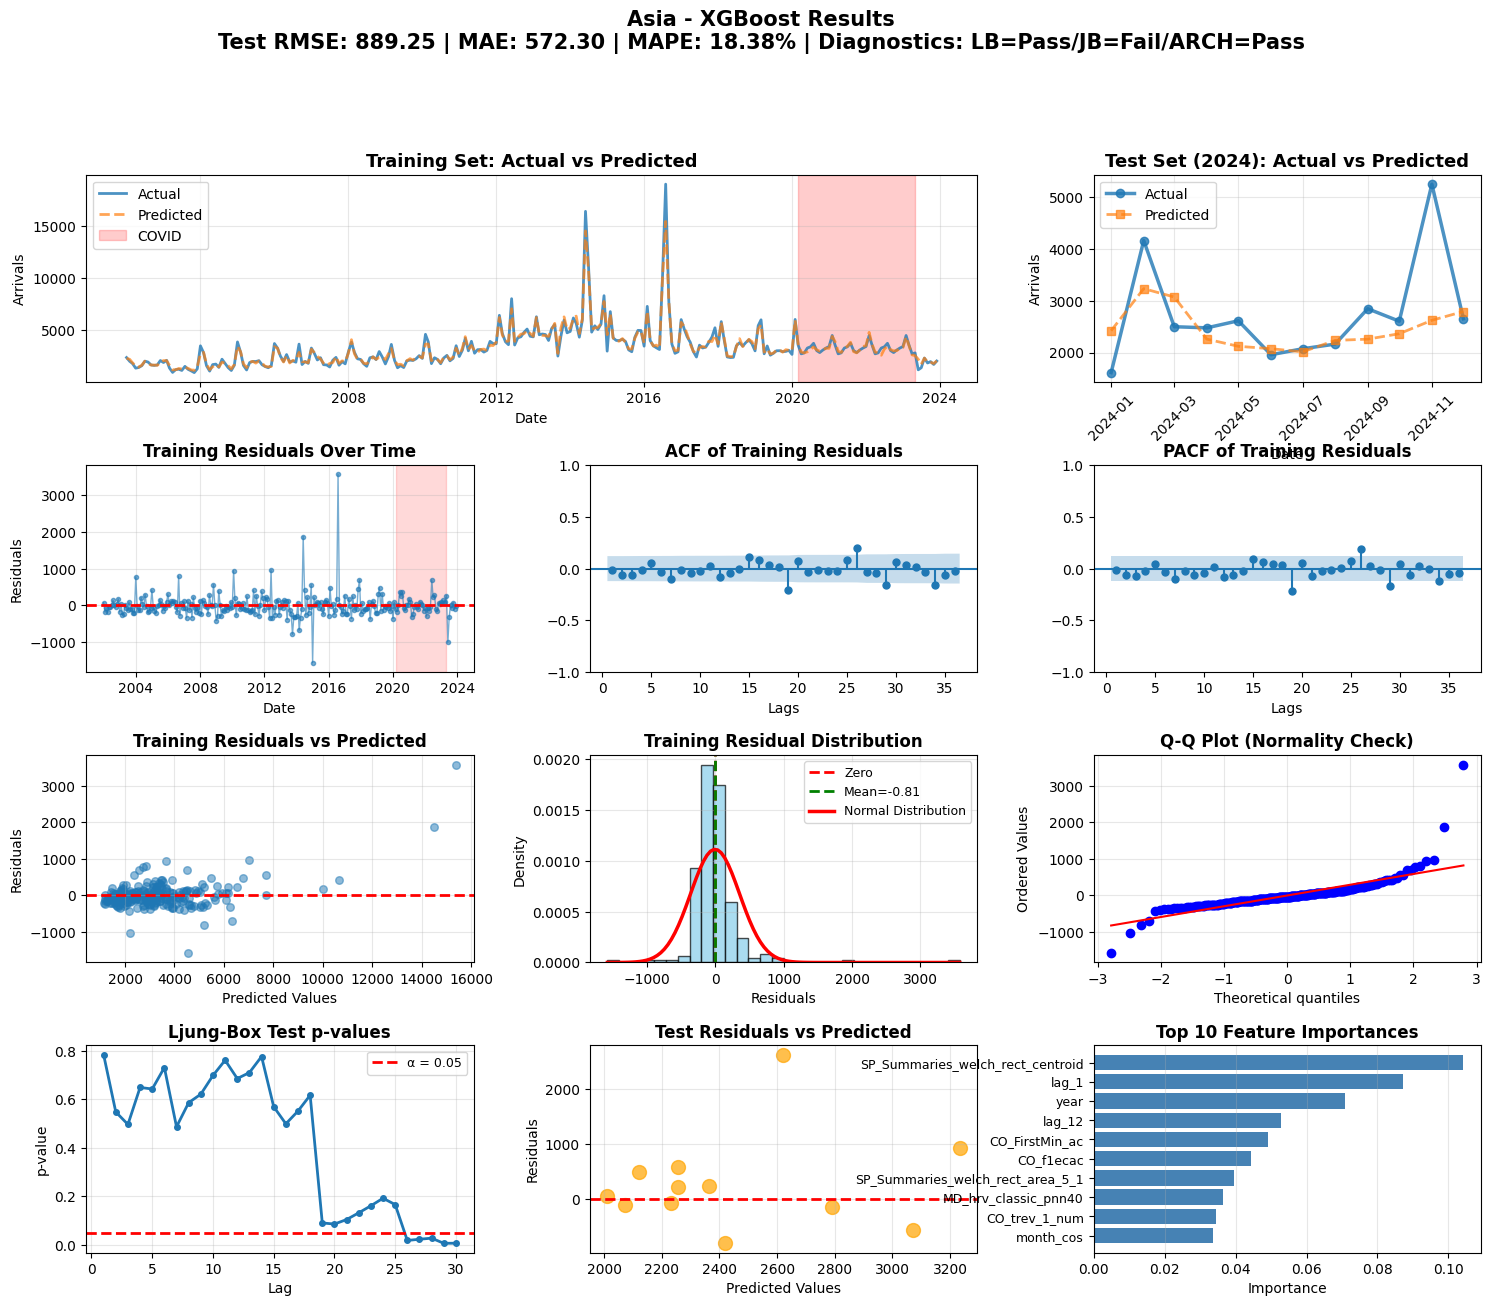


Gerando gráficos para: Europa

--- Residual Diagnostics (Training Set) ---
Residual Mean: 10.3352
Residual Std: 815.87

T-Test for Zero Mean:
  t-statistic: 0.2054
  p-value: 0.8374
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (40.79)

Ljung-Box Test (lag 24):
  p-value: 0.1132
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 316.3569
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.9788
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


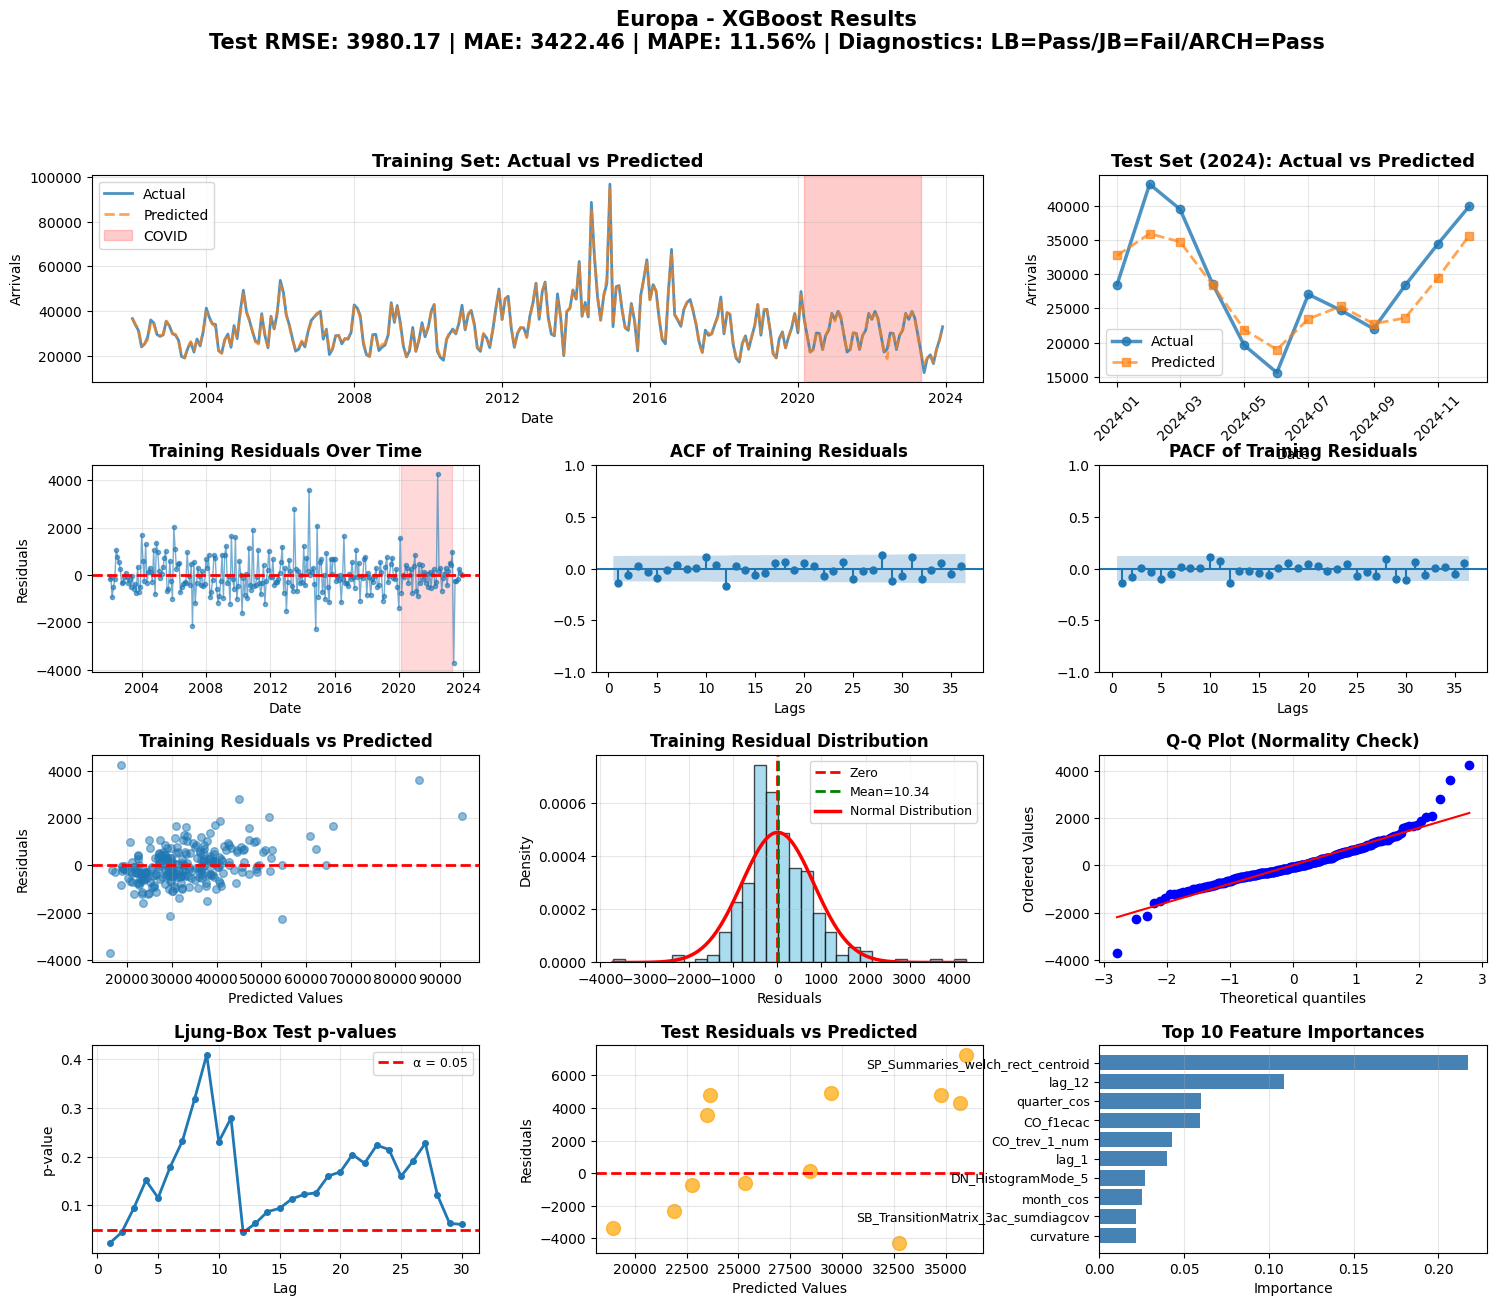


Gerando gráficos para: Oceania

--- Residual Diagnostics (Training Set) ---
Residual Mean: 3.7124
Residual Std: 290.21

T-Test for Zero Mean:
  t-statistic: 0.2075
  p-value: 0.8358
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (14.51)

Ljung-Box Test (lag 24):
  p-value: 0.1510
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 55572.9987
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 1.0000
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


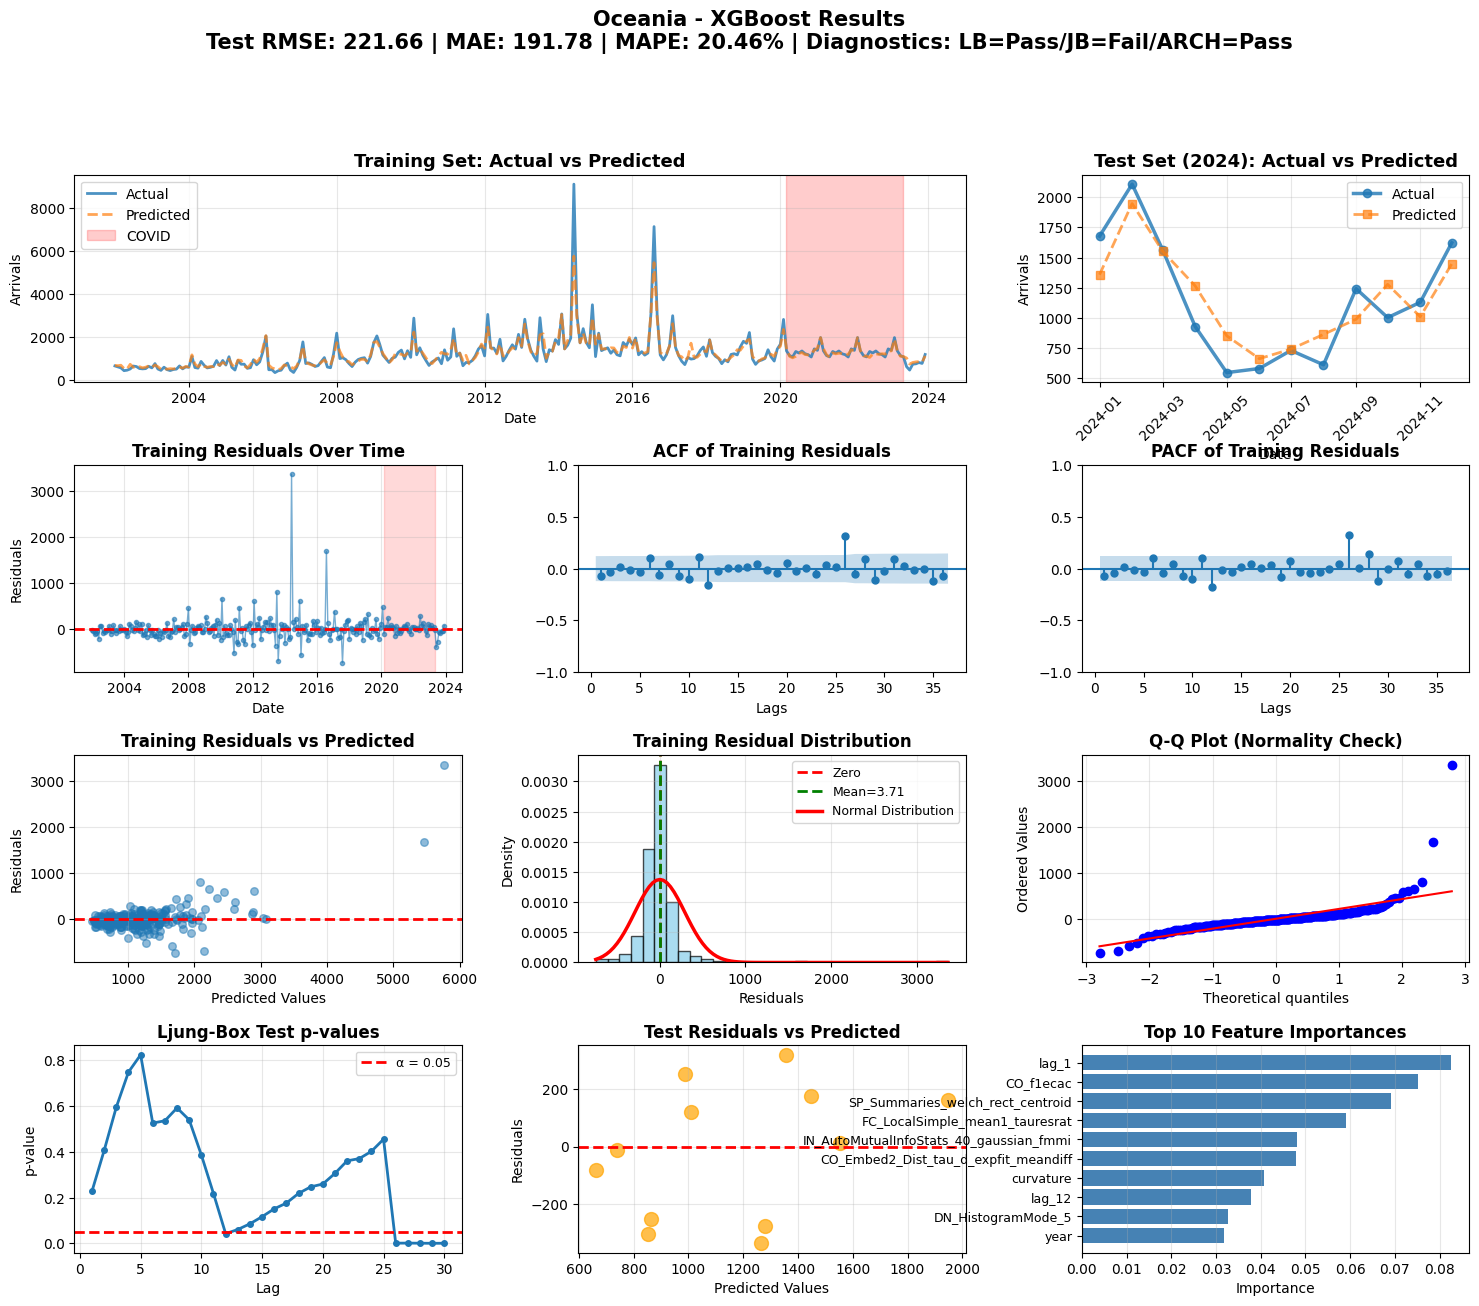


Gerando gráficos para: Total

--- Residual Diagnostics (Training Set) ---
Residual Mean: 21.3210
Residual Std: 8108.75

T-Test for Zero Mean:
  t-statistic: 0.0426
  p-value: 0.9660
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (405.44)

Ljung-Box Test (lag 24):
  p-value: 0.0968
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 21248.7565
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.8758
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


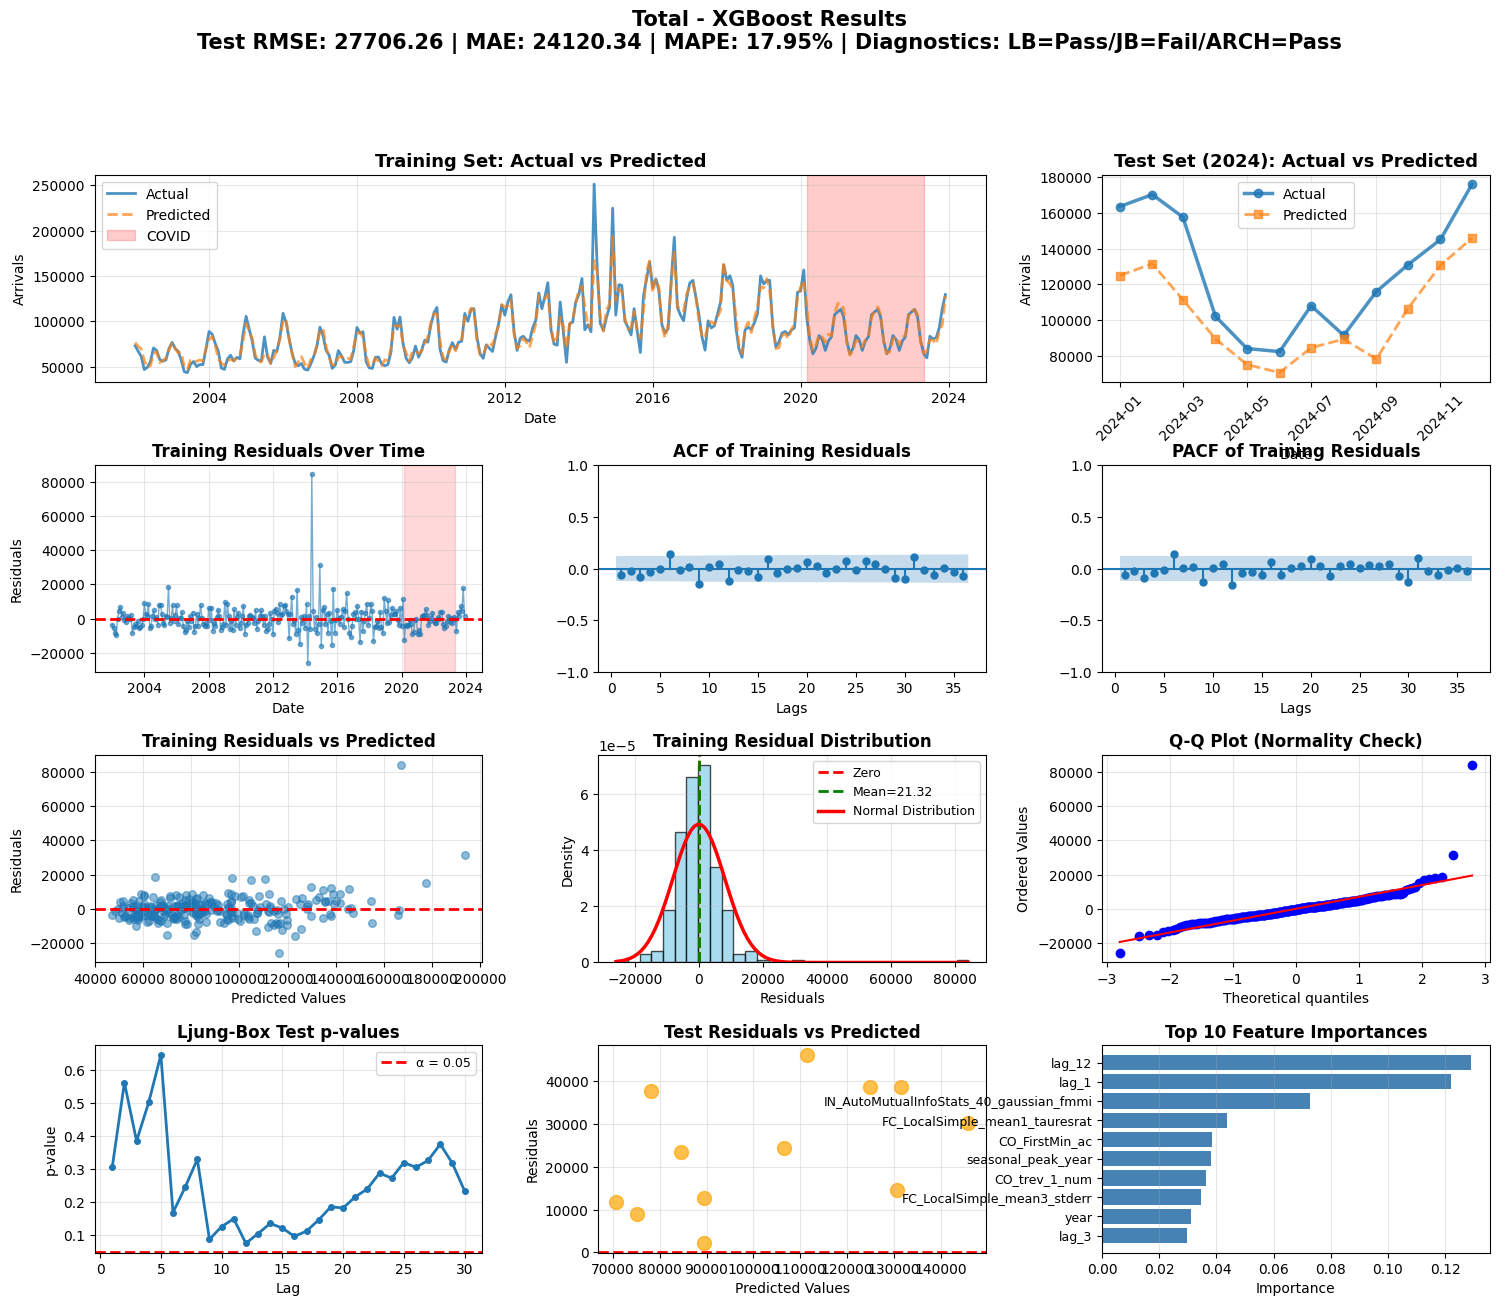


✓ Todas as visualizações criadas


In [58]:
print("="*80)
print("VISUALIZAÇÕES - XGBOOST RESULTADOS")
print("="*80 + "\n")

# Import necessário para ACF/PACF e testes estatísticos
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

# Para cada continente, criar gráficos
for continent in continents:
    if continent not in xgb_models:
        continue
    
    print(f"\nGerando gráficos para: {continent.title()}")
    
    model_data = xgb_models[continent]
    train_data = model_data['train_data']
    test_data = model_data['test_data']
    y_pred_train = model_data['y_pred_train']
    y_pred_test = model_data['y_pred_test']
    feature_importance = model_data['feature_importance']
    
    # Calculate residuals
    residuals_train = train_data['arrivals'].values - y_pred_train
    residuals_test = test_data['arrivals'].values - y_pred_test
    
    # ========================================
    # RESIDUAL DIAGNOSTICS
    # ========================================
    print(f"\n--- Residual Diagnostics (Training Set) ---")
    print(f"Residual Mean: {residuals_train.mean():.4f}")
    print(f"Residual Std: {residuals_train.std():.2f}")

        # 0. T-Test for Zero Mean (NEW!)
    print(f"\nT-Test for Zero Mean:")
    from scipy.stats import ttest_1samp
    t_stat, t_pvalue = ttest_1samp(residuals_train, 0)
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {t_pvalue:.4f}")
    
    # Calcular threshold baseado em % do desvio padrão
    threshold_5pct = 0.05 * residuals_train.std()
    threshold_10pct = 0.10 * residuals_train.std()
    mean_abs = abs(residuals_train.mean())
    
    if t_pvalue > 0.05:
        print(f"  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)")
        if mean_abs < threshold_5pct:
            print(f"  ✓✓ EXCELENTE: |Mean| < 5% do Std ({threshold_5pct:.2f})")
            mean_result = "Excellent"
        elif mean_abs < threshold_10pct:
            print(f"  ✓ BOM: |Mean| < 10% do Std ({threshold_10pct:.2f})")
            mean_result = "Good"
        else:
            print(f"  ⚠️ ACEITÁVEL: |Mean| > 10% do Std, mas estatisticamente = 0")
            mean_result = "Acceptable"
    else:
        print(f"  ✗ FAIL: Mean é significativamente diferente de zero (p < 0.05)")
        if residuals_train.mean() > 0:
            print(f"  → Modelo SUBESTIMA sistematicamente os valores reais")
        else:
            print(f"  → Modelo SUPERESTIMA sistematicamente os valores reais")
        mean_result = "Biased"
    
    # 1. Ljung-Box Test (autocorrelation) - 24 lags
    print(f"\nLjung-Box Test (lag 24):")
    lb_test = acorr_ljungbox(residuals_train, lags=16, return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[-1]  # Last lag p-value
    print(f"  p-value: {lb_pvalue:.4f}")
    if lb_pvalue > 0.05:
        print(f"  ✓ PASS: No significant autocorrelation (p > 0.05)")
        lb_result = "Pass"
    else:
        print(f"  ✗ FAIL: Significant autocorrelation detected (p < 0.05)")
        lb_result = "Fail"
    
    # 2. Jarque-Bera Test (normality)
    jb_stat, jb_pvalue = stats.jarque_bera(residuals_train)
    print(f"\nJarque-Bera Test (Normality):")
    print(f"  Statistic: {jb_stat:.4f}")
    print(f"  p-value: {jb_pvalue:.4f}")
    if jb_pvalue > 0.05:
        print(f"  ✓ PASS: Residuals are normally distributed (p > 0.05)")
        jb_result = "Pass"
    else:
        print(f"  ✗ FAIL: Residuals are not normally distributed (p < 0.05)")
        jb_result = "Fail"
    
    # 3. Heteroskedasticity (ARCH test)
    from statsmodels.stats.diagnostic import het_arch
    try:
        arch_test = het_arch(residuals_train, nlags=10)
        arch_pvalue = arch_test[1]
        print(f"\nARCH Test (Heteroskedasticity):")
        print(f"  p-value: {arch_pvalue:.4f}")
        if arch_pvalue > 0.05:
            print(f"  ✓ PASS: No heteroskedasticity (p > 0.05)")
            arch_result = "Pass"
        else:
            print(f"  ✗ FAIL: Heteroskedasticity detected (p < 0.05)")
            arch_result = "Fail"
    except:
        arch_result = "Error"
        arch_pvalue = np.nan
        print(f"\nARCH Test: Could not be performed")
    
    # Overall diagnostic result
    print(f"\n--- Overall Residual Diagnostics ---")
    all_pass = all([lb_result == "Pass", jb_result == "Pass", arch_result == "Pass"])
    if all_pass:
        print("✓✓✓ ALL TESTS PASSED - Model residuals are well-behaved")
        diagnostic_result = "All Pass"
    else:
        print("⚠️ SOME TESTS FAILED - Review residual diagnostics")
        diagnostic_result = "Some Fail"
    
    # ========================================
    # VISUALIZATION
    # ========================================
    
    # Create figure with subplots (aumentado para 4x3)
    fig = plt.figure(figsize=(18, 14))
    gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)
    
    # Plot 1: Train - Actual vs Predicted
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(train_data['date'], train_data['arrivals'], label='Actual', linewidth=2, alpha=0.8)
    ax1.plot(train_data['date'], y_pred_train, label='Predicted', linewidth=2, alpha=0.7, linestyle='--')
    ax1.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2023-05-01'), 
                alpha=0.2, color='red', label='COVID')
    ax1.set_title('Training Set: Actual vs Predicted', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Arrivals')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Test - Actual vs Predicted
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(test_data['date'], test_data['arrivals'], label='Actual', 
             linewidth=2.5, marker='o', markersize=6, alpha=0.8)
    ax2.plot(test_data['date'], y_pred_test, label='Predicted', 
             linewidth=2, alpha=0.7, marker='s', markersize=6, linestyle='--')
    ax2.set_title('Test Set (2024): Actual vs Predicted', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Arrivals')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Plot 3: Residuals Over Time (Train)
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(train_data['date'], residuals_train, marker='o', markersize=3, alpha=0.6, linewidth=1)
    ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax3.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2023-05-01'), 
                alpha=0.15, color='red')
    ax3.set_title('Training Residuals Over Time', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Date', fontsize=10)
    ax3.set_ylabel('Residuals', fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: ACF of Residuals (Training)
    ax4 = fig.add_subplot(gs[1, 1])
    plot_acf(residuals_train, lags=36, ax=ax4, zero=False)
    ax4.set_title('ACF of Training Residuals', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Lags', fontsize=10)
    
    # Plot 5: PACF of Residuals (Training)
    ax5 = fig.add_subplot(gs[1, 2])
    plot_pacf(residuals_train, lags=36, ax=ax5, zero=False, method='ywm')
    ax5.set_title('PACF of Training Residuals', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Lags', fontsize=10)
    
    # Plot 6: Residuals vs Fitted (Train)
    ax6 = fig.add_subplot(gs[2, 0])
    ax6.scatter(y_pred_train, residuals_train, alpha=0.5, s=30)
    ax6.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax6.set_title('Training Residuals vs Predicted', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Predicted Values', fontsize=10)
    ax6.set_ylabel('Residuals', fontsize=10)
    ax6.grid(True, alpha=0.3)
    
    # Plot 7: Histogram of Residuals with Normal Overlay
    ax7 = fig.add_subplot(gs[2, 1])
    ax7.hist(residuals_train, bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
    ax7.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero')
    ax7.axvline(x=residuals_train.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean={residuals_train.mean():.2f}')
    
    # Add normal distribution overlay
    mu, sigma = residuals_train.mean(), residuals_train.std()
    x = np.linspace(residuals_train.min(), residuals_train.max(), 100)
    ax7.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2.5, label='Normal Distribution')
    
    ax7.set_title('Training Residual Distribution', fontsize=12, fontweight='bold')
    ax7.set_xlabel('Residuals', fontsize=10)
    ax7.set_ylabel('Density', fontsize=10)
    ax7.legend(fontsize=9)
    ax7.grid(True, alpha=0.3)
    
    # Plot 8: Q-Q Plot (Normal probability plot)
    ax8 = fig.add_subplot(gs[2, 2])
    stats.probplot(residuals_train, dist="norm", plot=ax8)
    ax8.set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
    ax8.grid(True, alpha=0.3)
    
    # Plot 9: Ljung-Box p-values by Lag
    ax9 = fig.add_subplot(gs[3, 0])
    lb_test_full = acorr_ljungbox(residuals_train, lags=30, return_df=True)
    ax9.plot(lb_test_full.index, lb_test_full['lb_pvalue'], marker='o', linewidth=2, markersize=4)
    ax9.axhline(y=0.05, color='r', linestyle='--', linewidth=2, label='α = 0.05')
    ax9.set_title('Ljung-Box Test p-values', fontsize=12, fontweight='bold')
    ax9.set_xlabel('Lag', fontsize=10)
    ax9.set_ylabel('p-value', fontsize=10)
    ax9.legend(fontsize=9)
    ax9.grid(True, alpha=0.3)
    
    # Plot 10: Test Residuals vs Predicted
    ax10 = fig.add_subplot(gs[3, 1])
    ax10.scatter(y_pred_test, residuals_test, alpha=0.7, s=100, color='orange')
    ax10.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax10.set_title('Test Residuals vs Predicted', fontsize=12, fontweight='bold')
    ax10.set_xlabel('Predicted Values', fontsize=10)
    ax10.set_ylabel('Residuals', fontsize=10)
    ax10.grid(True, alpha=0.3)
    
    # Plot 11: Feature Importance
    ax11 = fig.add_subplot(gs[3, 2])
    top_features = feature_importance.head(10)
    ax11.barh(range(len(top_features)), top_features['importance'], color='steelblue')
    ax11.set_yticks(range(len(top_features)))
    ax11.set_yticklabels(top_features['feature'], fontsize=9)
    ax11.invert_yaxis()
    ax11.set_title('Top 10 Feature Importances', fontsize=12, fontweight='bold')
    ax11.set_xlabel('Importance', fontsize=10)
    ax11.grid(True, alpha=0.3, axis='x')
    
    # Overall title
    continent_display = "TOTAL (Agregado)" if continent == 'TOTAL' else continent.title()
    
    # ✅ FIX: Buscar pelo nome ORIGINAL (lowercase) em results_df
    result = results_df[results_df['Continent'] == continent].iloc[0]
    
    plt.suptitle(f"{continent.title()} - XGBoost Results\n" + 
                 f"Test RMSE: {result['Test_RMSE']:.2f} | MAE: {result['Test_MAE']:.2f} | MAPE: {result['Test_MAPE']:.2f}% | " +
                 f"Diagnostics: LB={lb_result}/JB={jb_result}/ARCH={arch_result}",
                 fontsize=15, fontweight='bold', y=0.998)
    
    plt.show()

print("\n✓ Todas as visualizações criadas")